
<font size="20"><h3 align='center'>**_DSL Project_**</font><br>
    
    
<font size="5"><h3 align='center'><span style='color:Blue'> Predict impact of air quality on mortality rates(Kaggle Competition)</font>


<font size="3"><h3 align='center'>https://www.kaggle.com/c/predict-impact-of-air-quality-on-death-rates/overview</font><br>
    <br>


<font size="3">**Group Number - 2**<br>
<font size="3"> Mimansi Agarwal   &emsp;19BM6JP15</font>        
<font size="3"> Vaibhav HK Anand  &emsp;19BM6JP24</font>    
<font size="3"> Bankar Prasad Vilas &emsp;19BM6JP25</font> 


## TO DO

- ANOVA on variables per region
- XGB Regressor
- Best depth via cost pruning for RFR
- Graphs for regulartization 

# Libraries

In [0]:
#!pip install impyute

In [0]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from impyute.imputation.cs import mice
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import  make_scorer
import math

import missingno as msno

import plotly.express as px
import plotly.graph_objects as go

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

import gc

# Data import

In [0]:
train = pd.read_csv('/content/train.csv', parse_dates=['date'], index_col='Id')
test = pd.read_csv('/content/test.csv', parse_dates=['date'], index_col='Id')
region=pd.read_csv('/content/regions.csv')

In [451]:
train.head()

,region,date,mortality_rate,O3,PM10,PM25,NO2,T2M
Id,,,,,,,,
1,E12000001,2007-01-02,2.264,42.358,9.021,NaN,NaN,278.138
2,E12000001,2007-01-03,2.030,49.506,5.256,NaN,NaN,281.745
3,E12000001,2007-01-04,1.874,51.101,4.946,NaN,NaN,280.523
4,E12000001,2007-01-05,2.069,47.478,6.823,NaN,NaN,280.421
5,E12000001,2007-01-06,1.913,45.226,7.532,NaN,NaN,278.961


In [0]:
def reduce_mem_usage(df, verbose=True):
    '''
    Reduces the usage of memory by a dataframe
    '''
    start_mem = df.memory_usage().sum() / 2**20
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] #defining a list of numeric types
    #start_mem = df.memory_usage().sum() / 2**20   #converting bytes into MB
    for col in df.columns: # iterating over each column of dataframe
        col_type = df[col].dtypes # extracting the data type of a single column
        if col_type in numerics: # checking whether the data type of column is a numeric datatype or not
            c_min = df[col].min()
            c_max = df[col].max()
          
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                df[col] = df[col].astype('float16')
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df[col] = df[col].astype('float32')
            else:
                df[col] = df[col].astype('float64')    
    end_mem = df.memory_usage().sum() / 2**20
    if verbose: print('Mem. usage decreased to {:5.5f} Mb ({:.2f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Exploratory data analysis

In [0]:
#train = reduce_mem_usage(train)
#test = reduce_mem_usage(test)

In [456]:
region

,Code,Region
0,E12000001,North East
1,E12000002,North West
2,E12000003,Yorkshire and The Humber
3,E12000004,East Midlands
4,E12000005,West Midlands
5,E12000006,East of England
6,E12000007,London
7,E12000008,South East
8,E12000009,South West


In [457]:
# Checking that the date column is monotonic
for r in train['region'].unique():
  print(train[train['region']==r]['date'].is_monotonic)
del r

True
True
True
True
True
True
True
True
True


In [458]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18403 entries, 1 to 18403
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   region          18403 non-null  object        
 1   date            18403 non-null  datetime64[ns]
 2   mortality_rate  18403 non-null  float64       
 3   O3              18394 non-null  float64       
 4   PM10            18394 non-null  float64       
 5   PM25            15127 non-null  float64       
 6   NO2             11833 non-null  float64       
 7   T2M             18403 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 1.3+ MB


In [461]:
train.describe()

,mortality_rate,O3,PM10,PM25,NO2,T2M
count,18403.000000,18394.000000,18394.000000,15127.000000,11833.000000,18403.000000
mean,1.301737,45.325857,13.712272,7.498714,12.045813,283.002235
std,0.304161,16.221330,7.421616,5.758357,8.296675,5.182186
min,0.439000,0.988000,2.020000,0.904000,1.104000,265.562000
25%,1.102000,35.074250,8.656250,3.624000,6.056000,279.321500
50%,1.281000,45.836000,11.704500,5.636000,9.769000,283.270000
75%,1.474000,55.881000,16.589000,9.326500,15.858000,287.240500
max,2.841000,105.693000,60.627000,45.846000,76.765000,297.209000


In [462]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7886 entries, 18404 to 26289
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   region  7886 non-null   object        
 1   date    7886 non-null   datetime64[ns]
 2   O3      7886 non-null   float64       
 3   PM10    7886 non-null   float64       
 4   PM25    7886 non-null   float64       
 5   NO2     7886 non-null   float64       
 6   T2M     7886 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 492.9+ KB


In [463]:
test.describe()

,O3,PM10,PM25,NO2,T2M
count,7886.000000,7886.000000,7886.000000,7886.000000,7886.000000
mean,49.527998,14.545470,8.749311,13.140902,283.410366
std,16.086797,7.660908,6.437121,8.848008,5.274034
min,1.559000,2.506000,0.850000,1.386000,268.696000
25%,39.843000,9.467250,4.620250,6.732750,279.458500
50%,50.935500,12.364000,6.810000,10.627500,283.518000
75%,60.379000,17.353750,10.872000,16.864750,287.707250
max,103.718000,67.361000,56.717000,67.063000,296.740000


In [470]:
region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Code    9 non-null      object
 1   Region  9 non-null      object
dtypes: object(2)
memory usage: 272.0+ bytes


## Missing Values

In [464]:
train.isna().sum()

region               0
date                 0
mortality_rate       0
O3                   9
PM10                 9
PM25              3276
NO2               6570
T2M                  0
dtype: int64

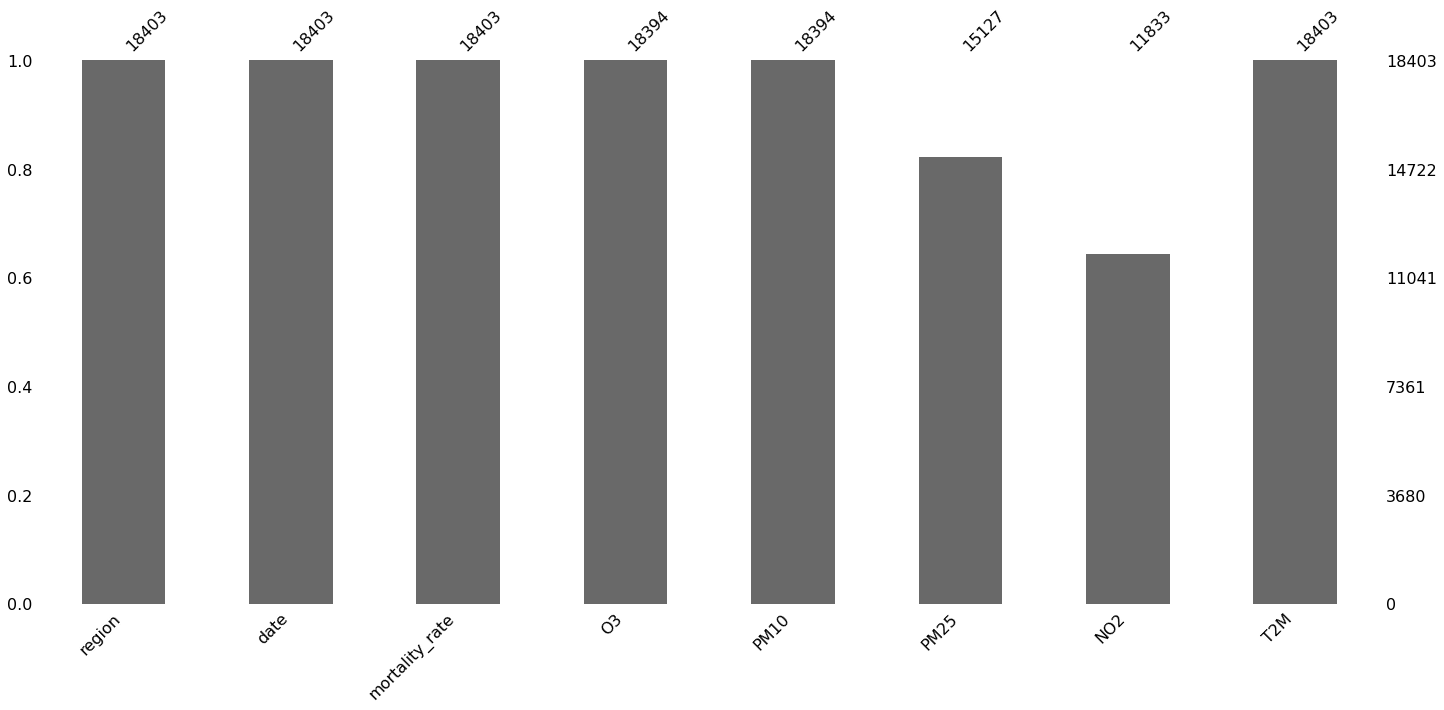

In [465]:
msno.bar(train)

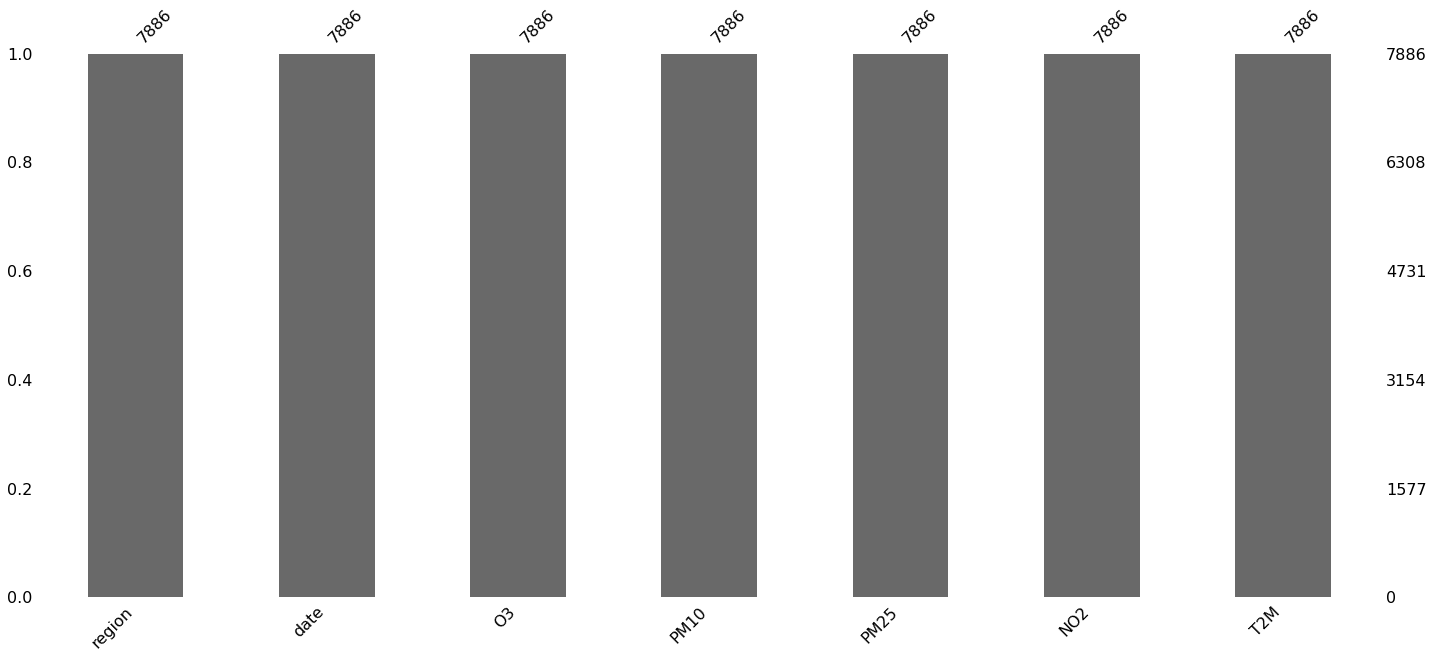

In [466]:
msno.bar(test)

# No missing values

AxesSubplot(0.125,0.125;0.698618x0.755)
AxesSubplot(0.125,0.125;0.698618x0.755)
AxesSubplot(0.125,0.125;0.698618x0.755)
AxesSubplot(0.125,0.125;0.698618x0.755)
AxesSubplot(0.125,0.125;0.698618x0.755)
AxesSubplot(0.125,0.125;0.698618x0.755)
AxesSubplot(0.125,0.125;0.698618x0.755)
AxesSubplot(0.125,0.125;0.698618x0.755)
AxesSubplot(0.125,0.125;0.698618x0.755)


38111

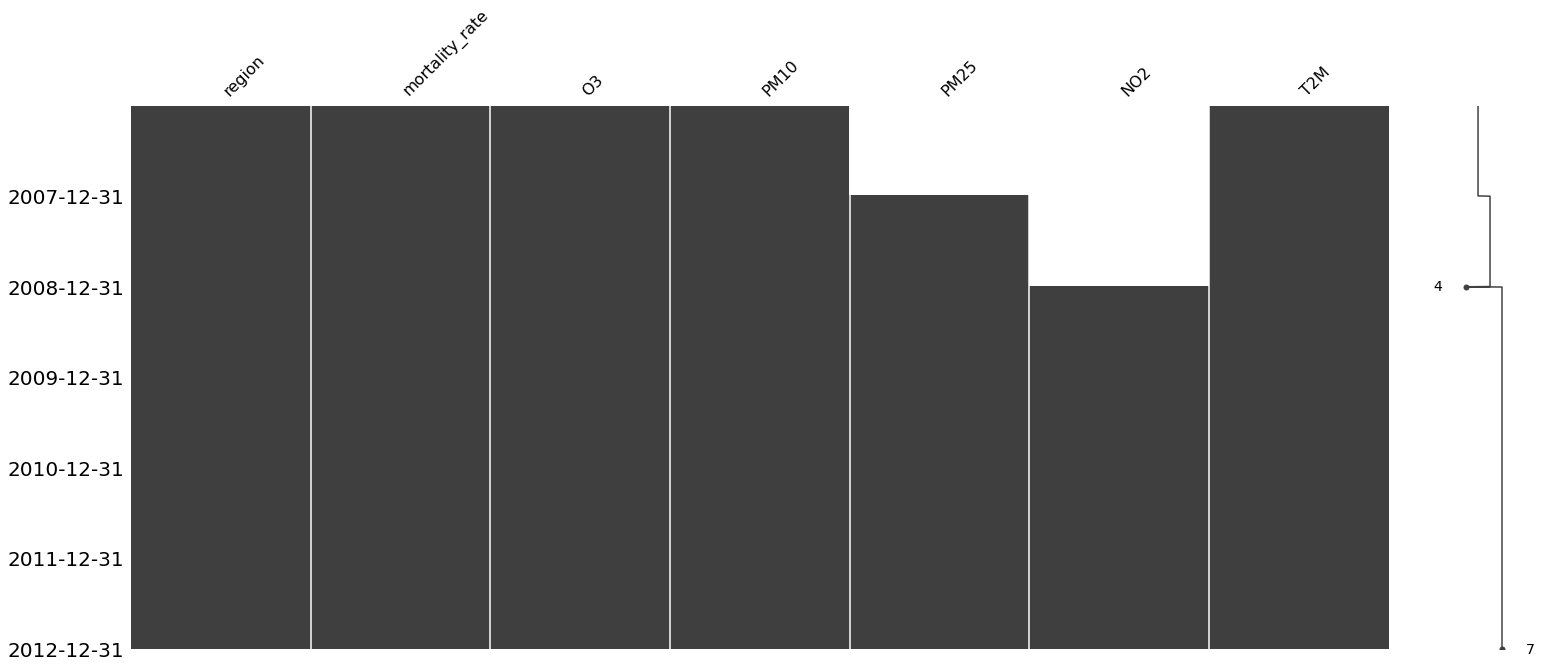

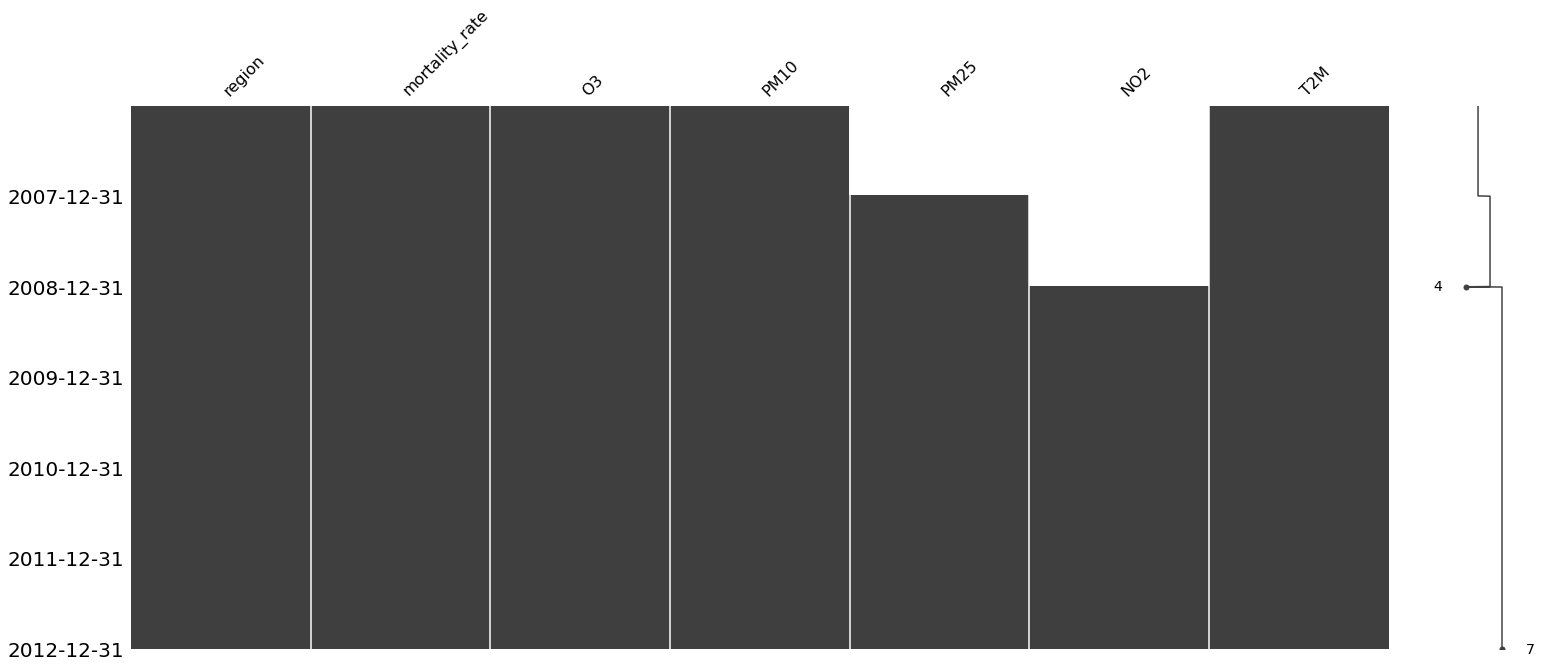

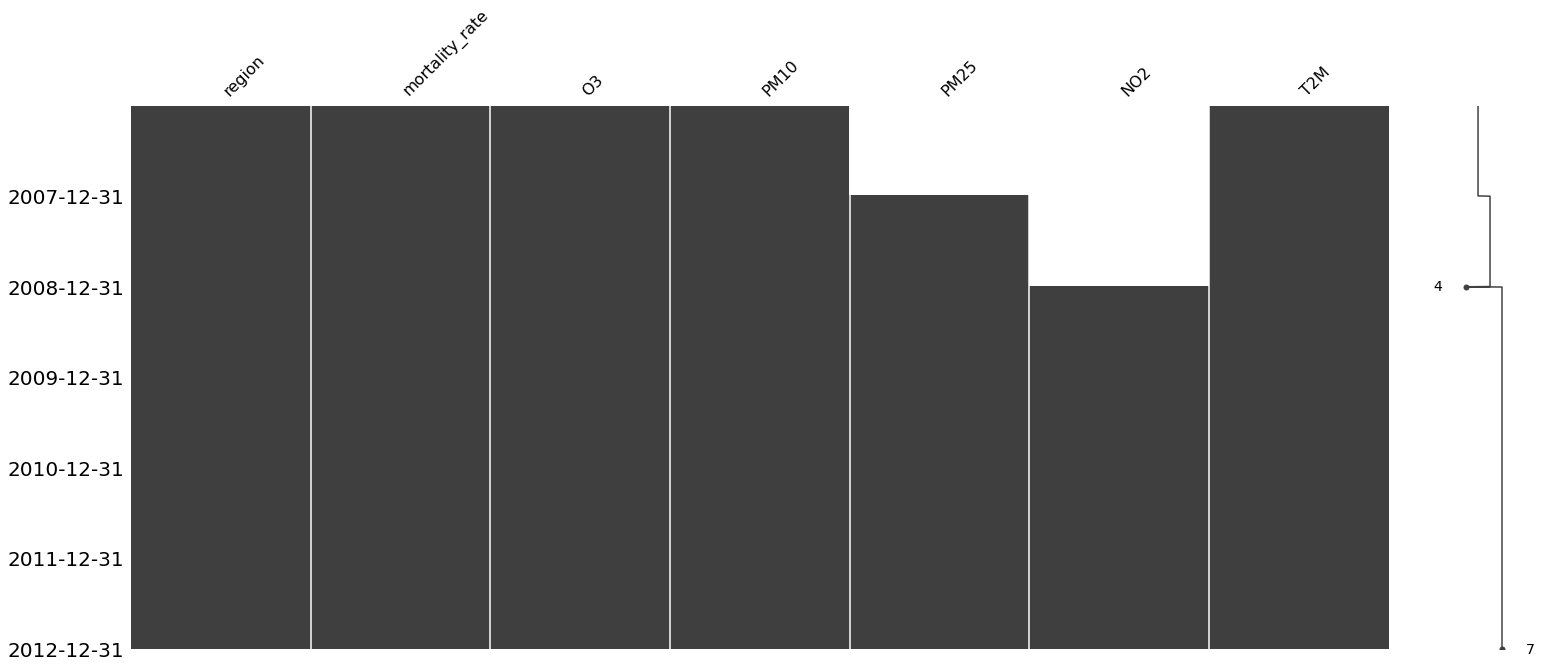

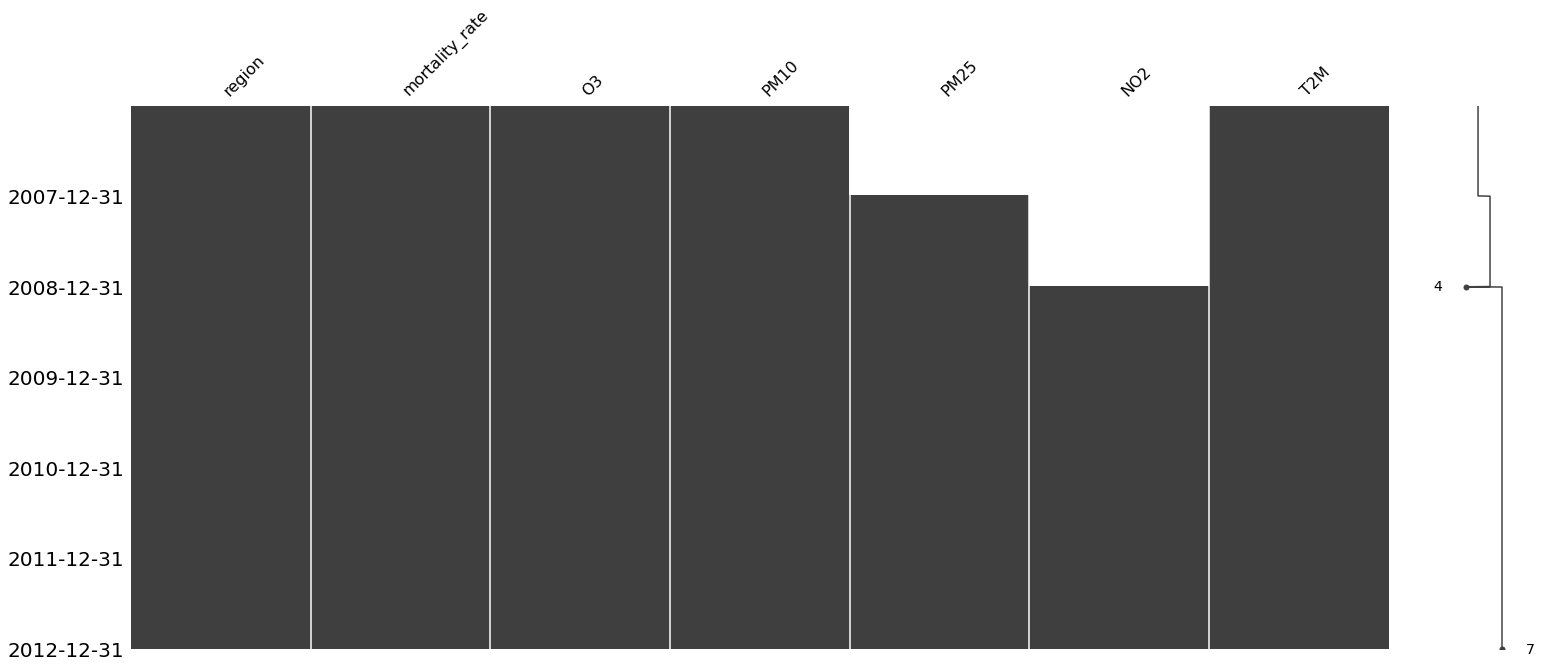

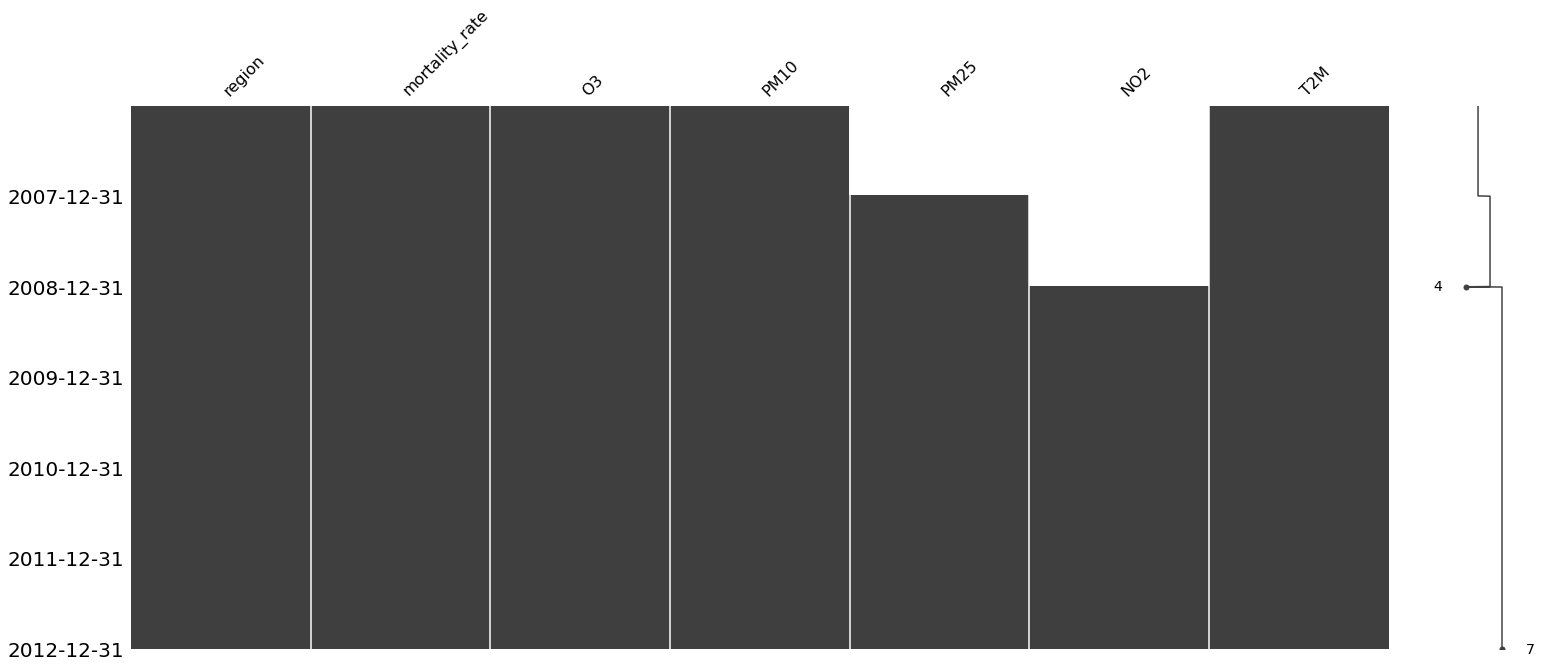

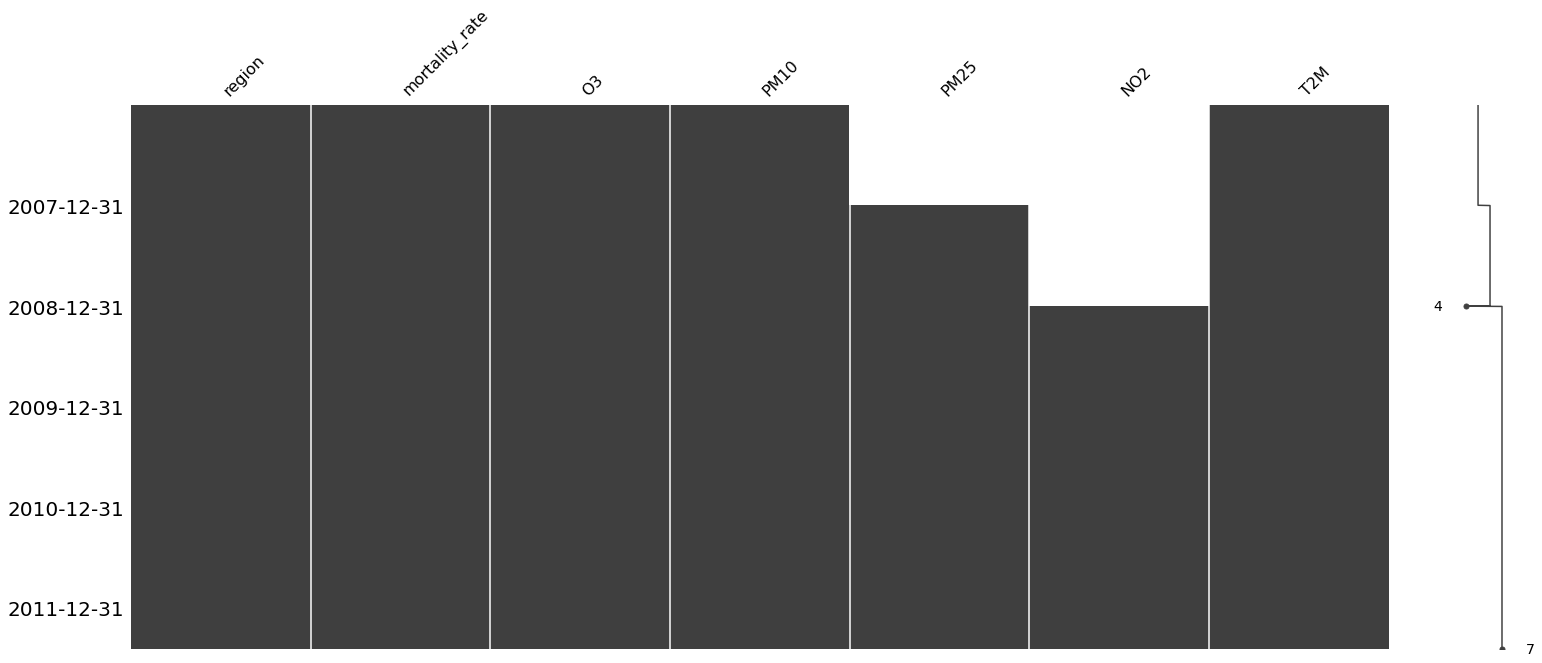

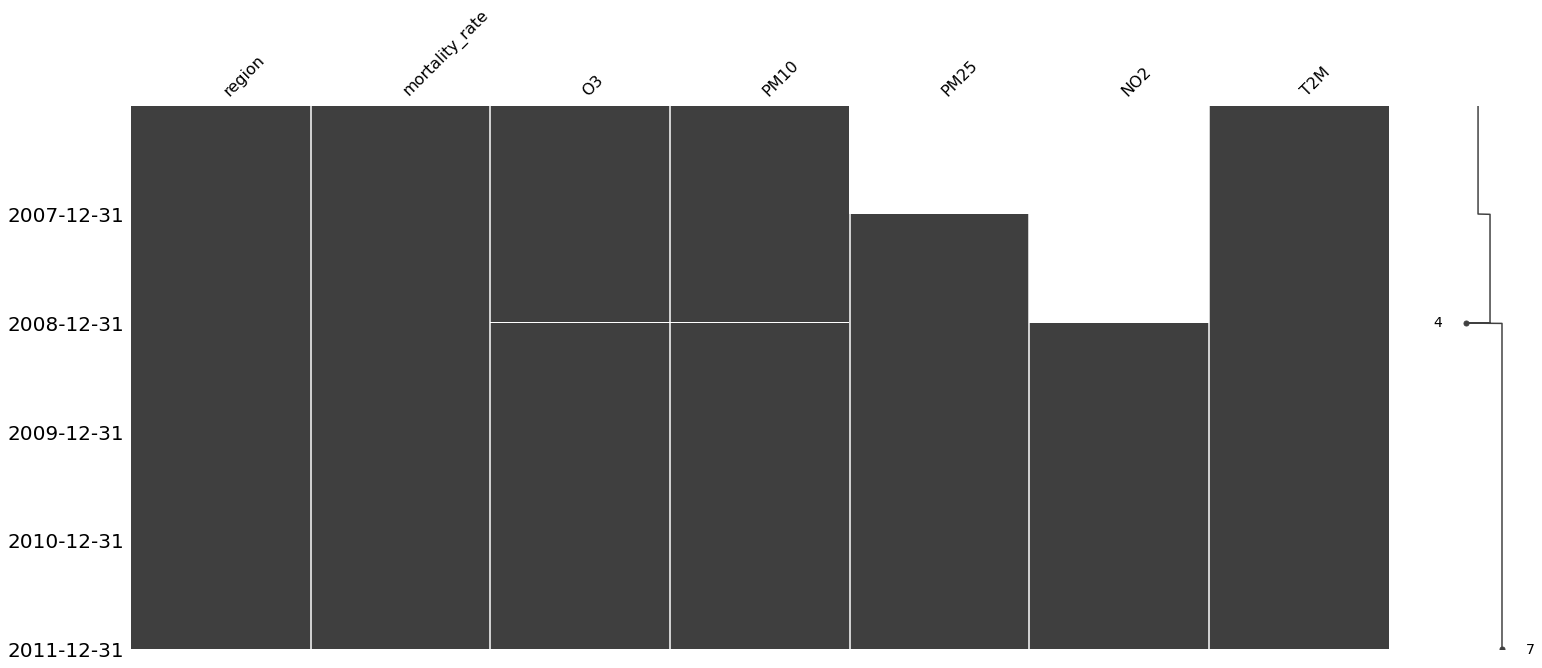

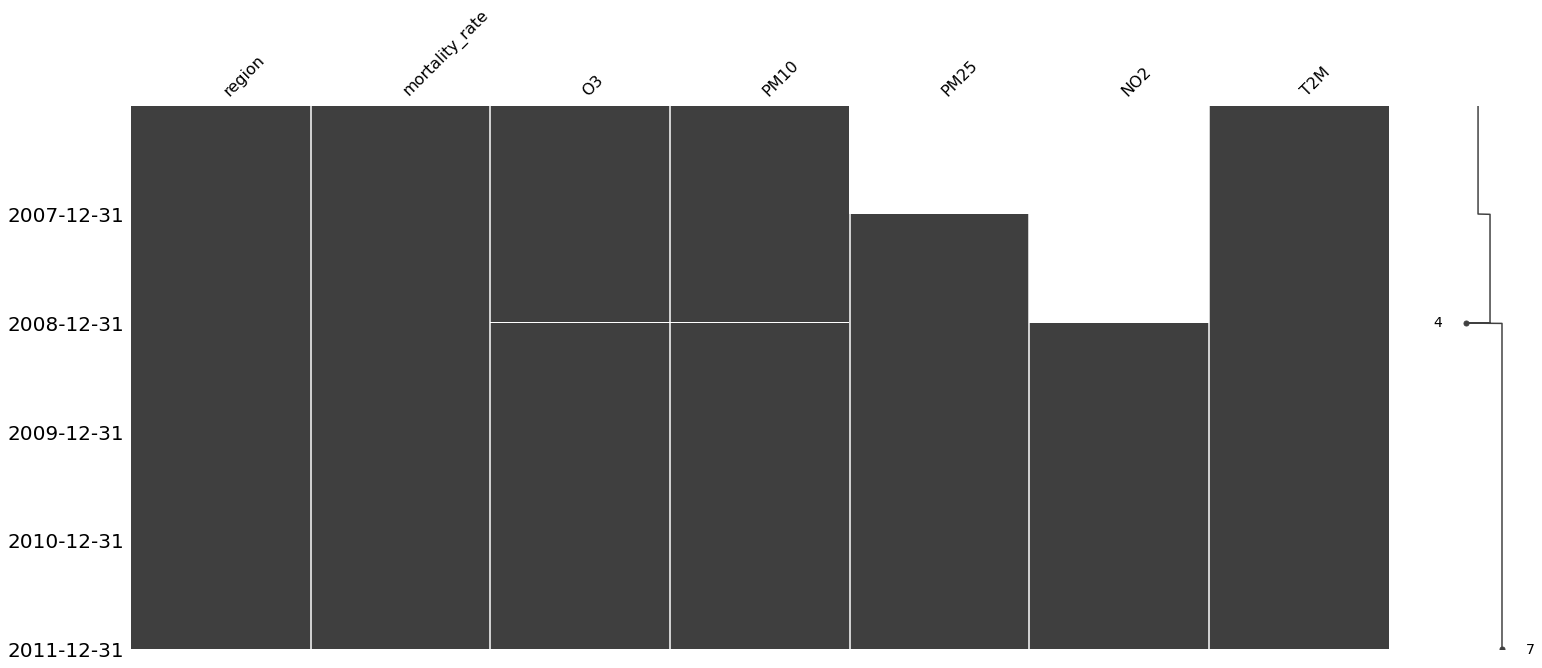

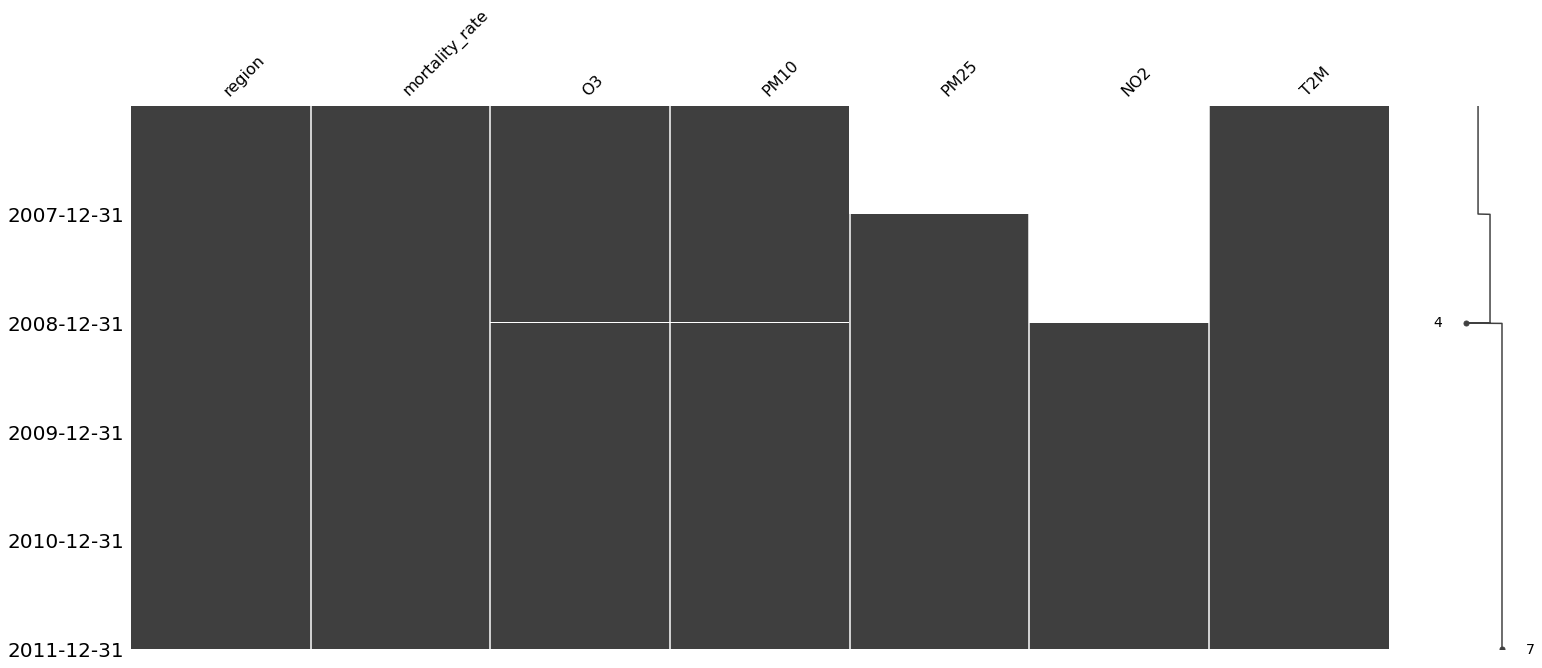

In [475]:
temp = train.set_index('date')

for r in train['region'].unique():
  t = temp[temp['region']==r]
  print(msno.matrix(t, freq = 'A'))

del temp, t
gc.collect()

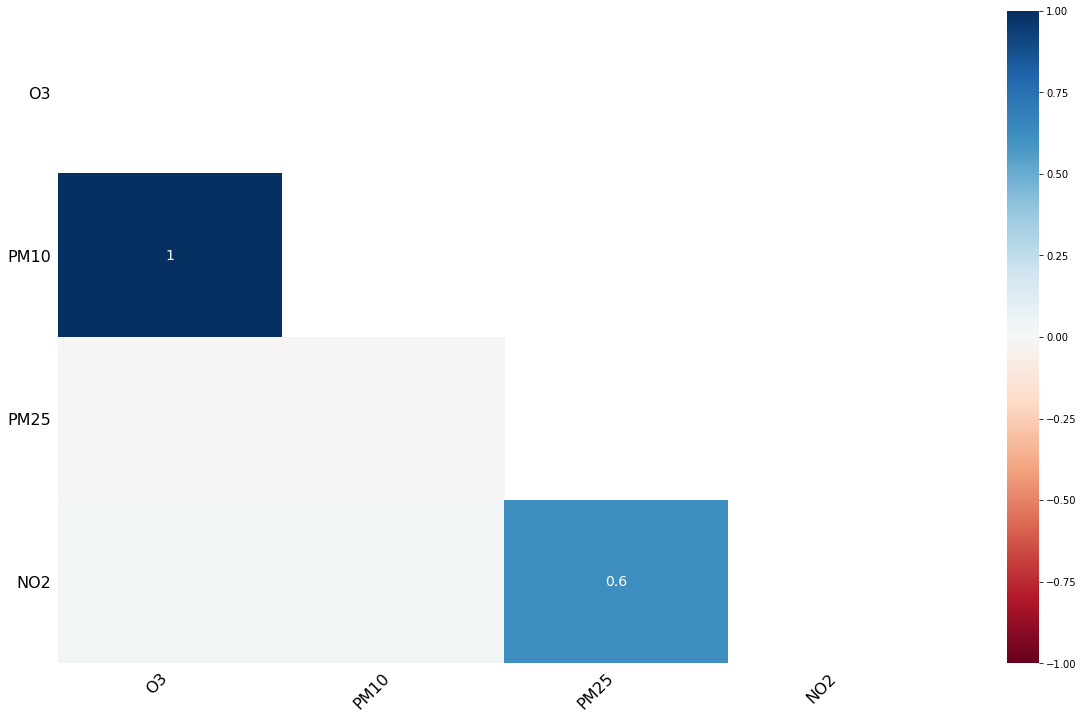

In [347]:
msno.heatmap(train)

# https://github.com/ResidentMario/missingno

# correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another
# Variables that are always full or always empty have no meaningful correlation, and so are silently removed from the visualization—in this case for instance the datetime and injury number columns, which are completely filled, are not included.

AxesSubplot(0.125,0.125;0.62x0.755)
AxesSubplot(0.125,0.125;0.62x0.755)
AxesSubplot(0.125,0.125;0.62x0.755)
AxesSubplot(0.125,0.125;0.62x0.755)
AxesSubplot(0.125,0.125;0.62x0.755)
AxesSubplot(0.125,0.125;0.62x0.755)
AxesSubplot(0.125,0.125;0.62x0.755)
AxesSubplot(0.125,0.125;0.62x0.755)
AxesSubplot(0.125,0.125;0.62x0.755)


76082

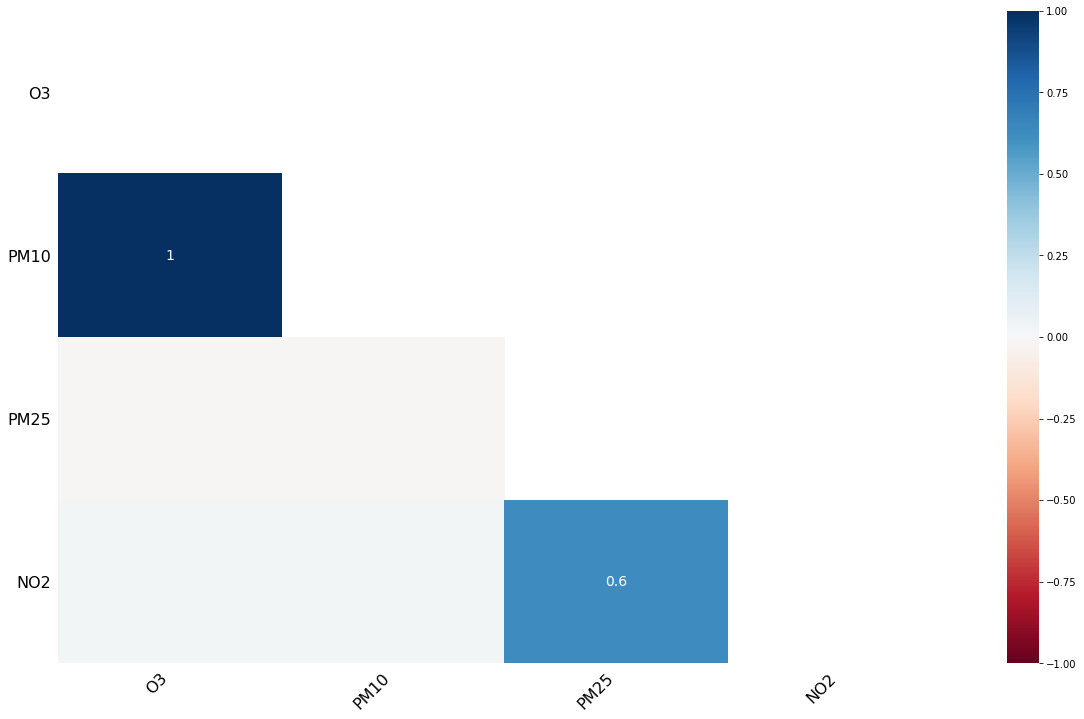

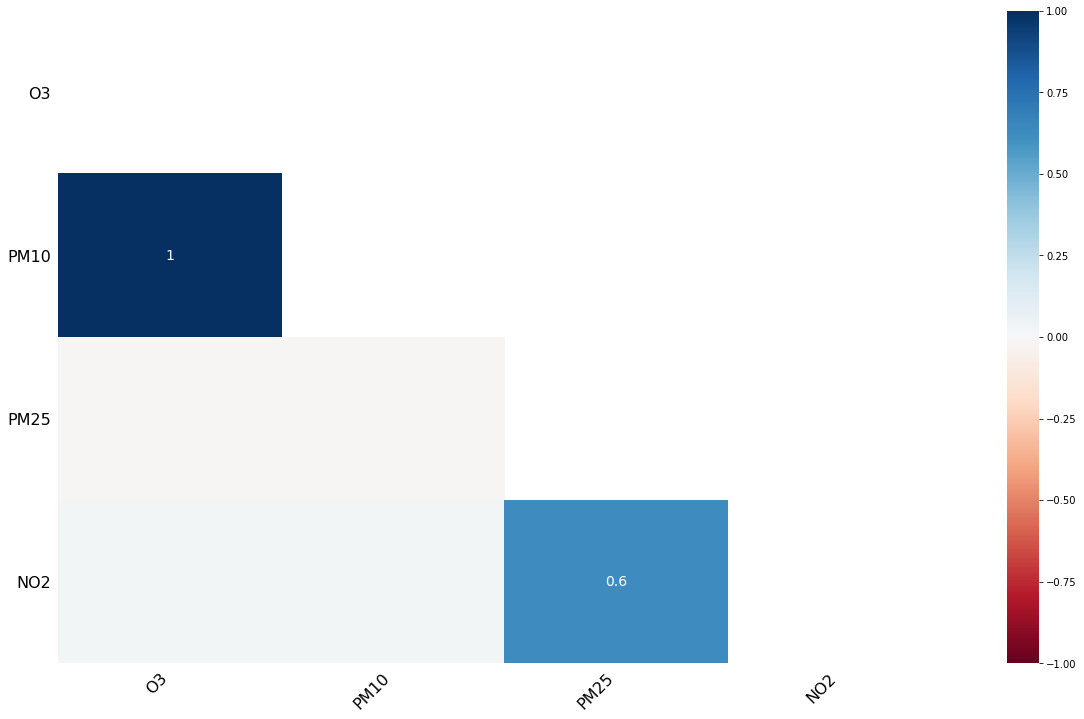

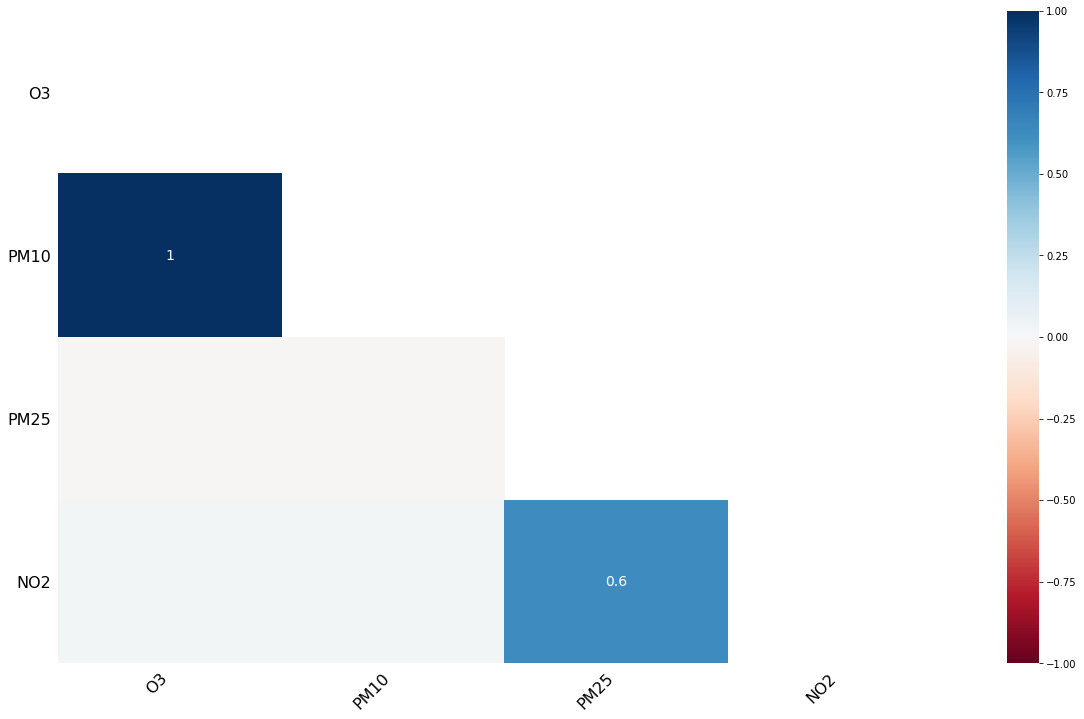

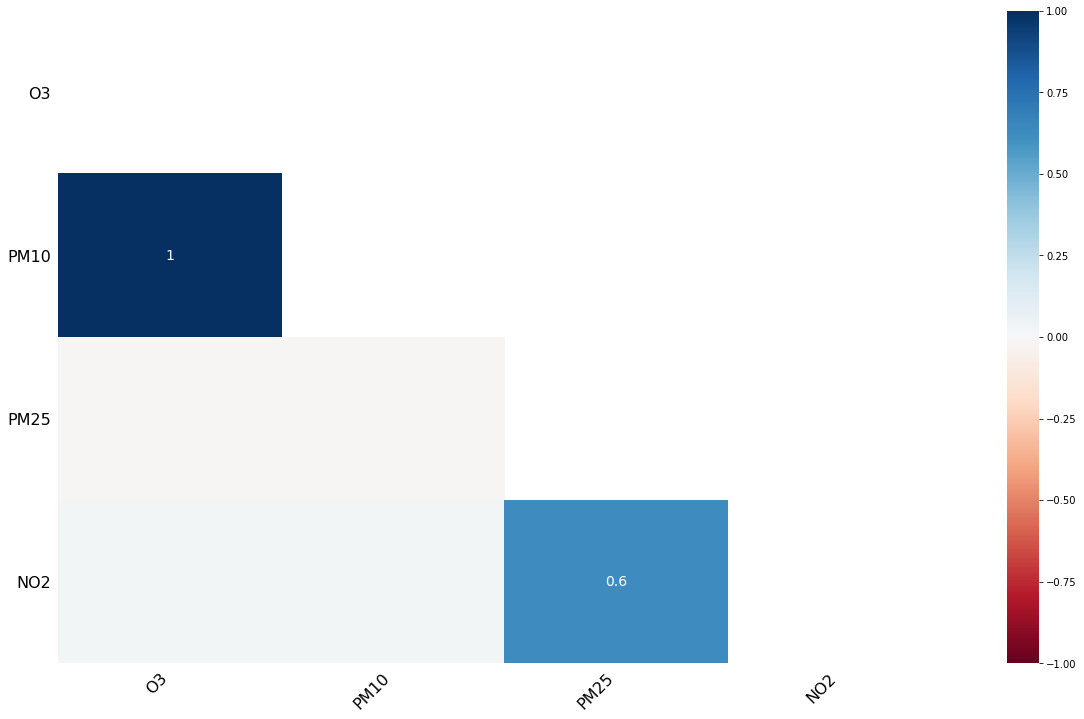

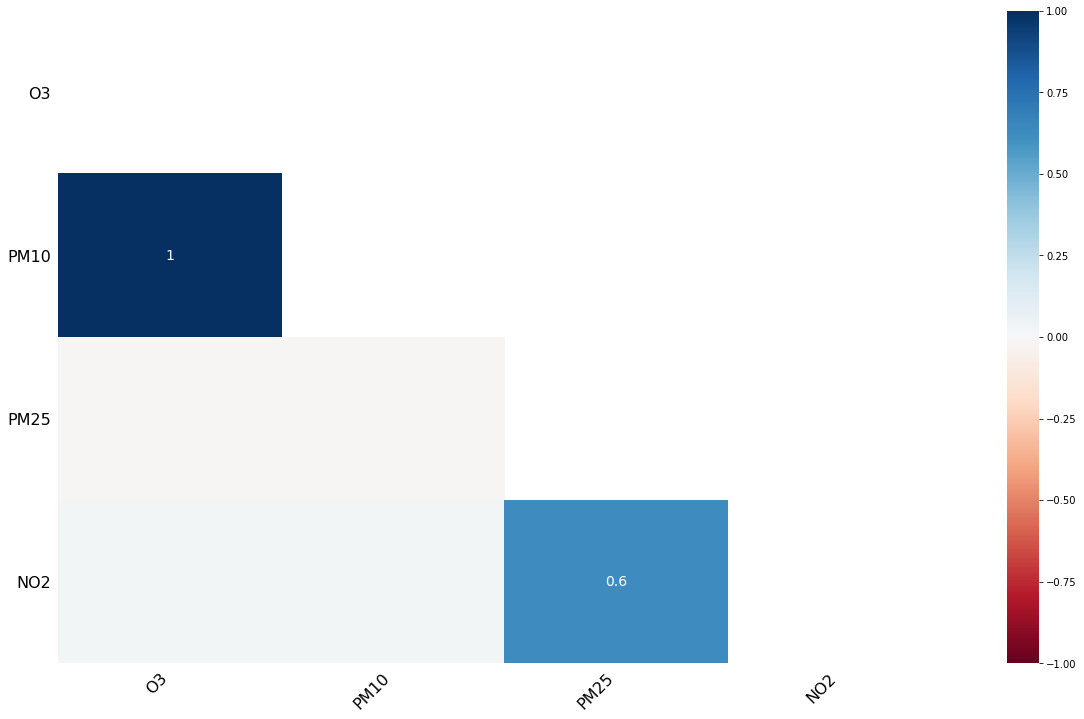

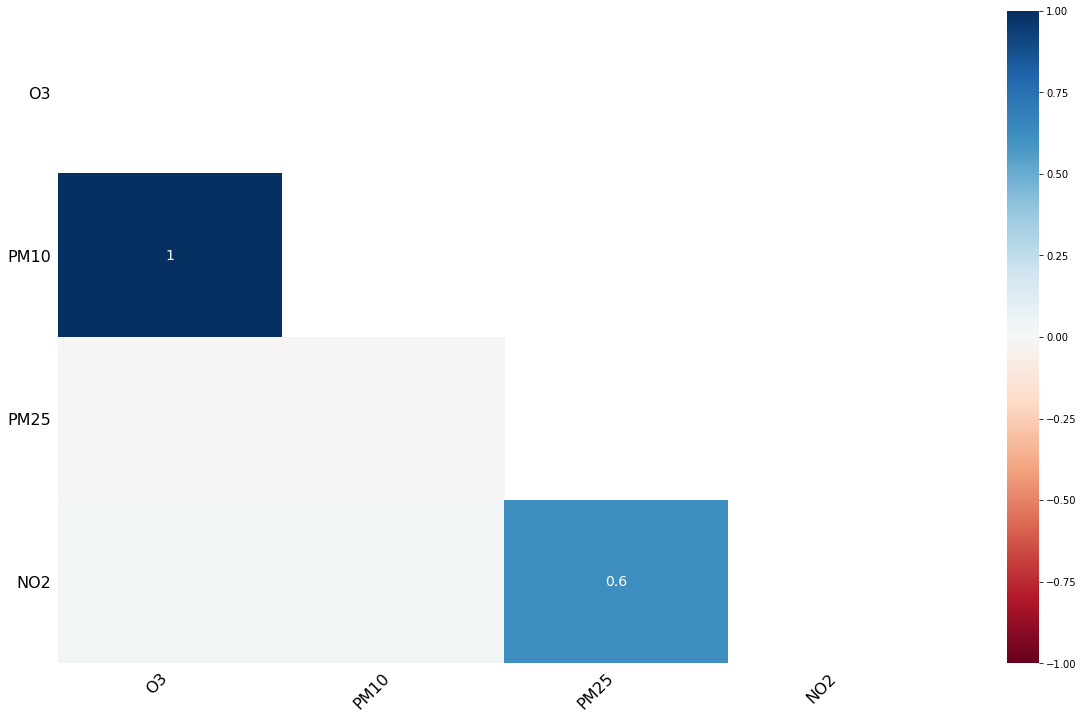

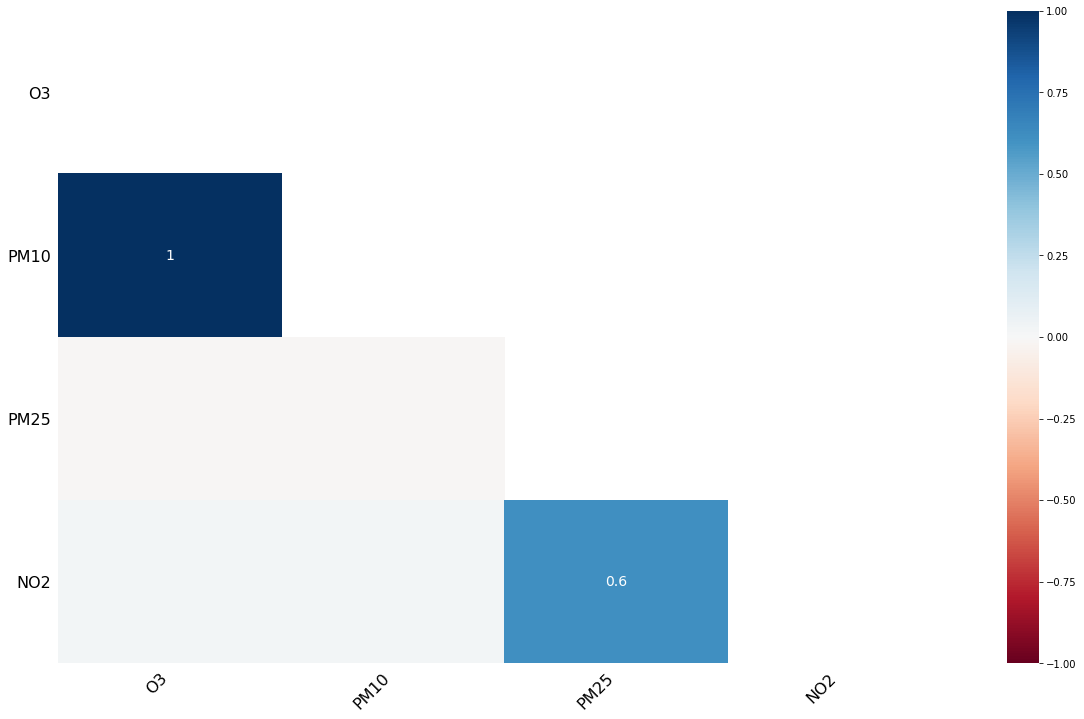

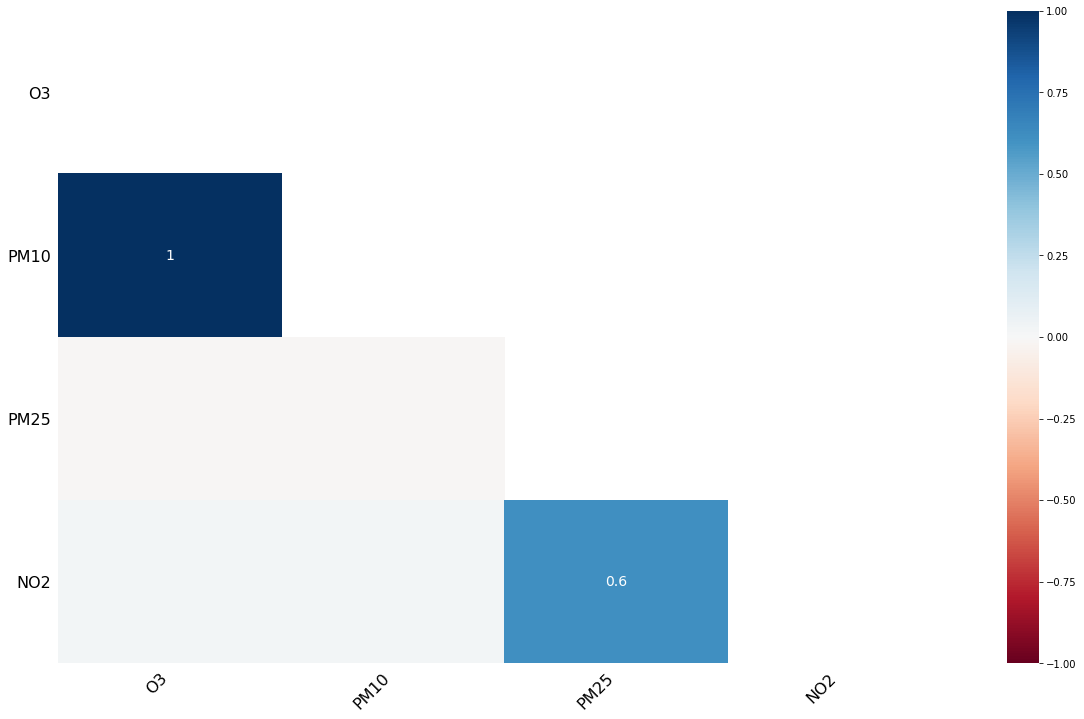

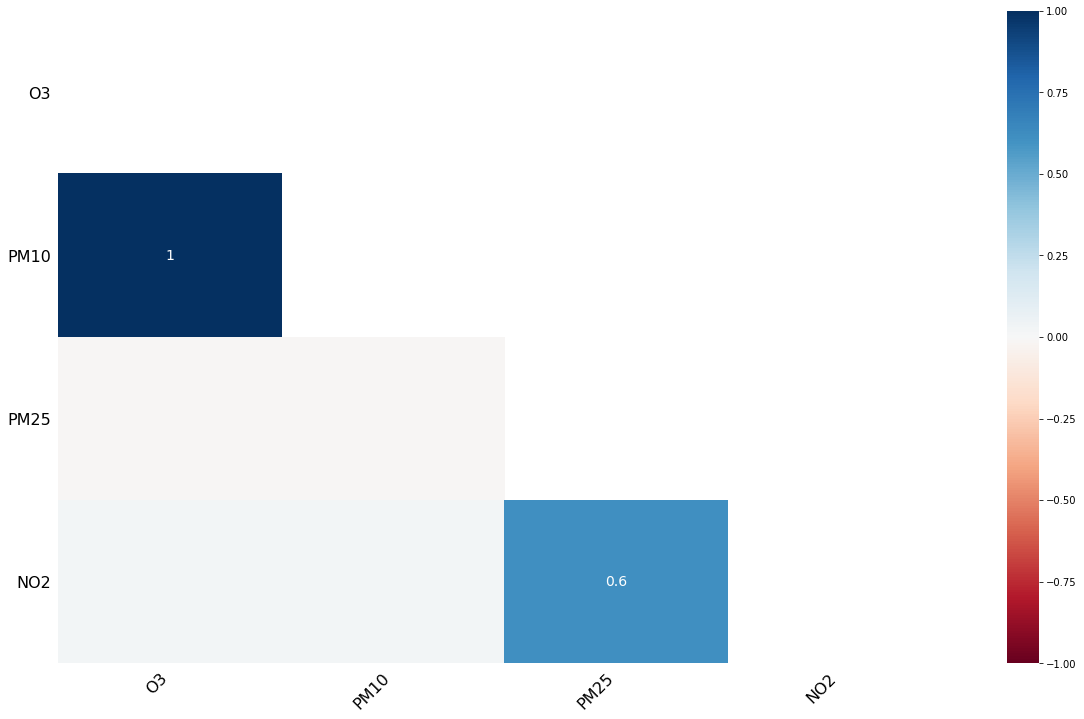

In [478]:
for r in train['region'].unique():
  t = train[train['region']==r]
  print(msno.heatmap(t))

del t
gc.collect()

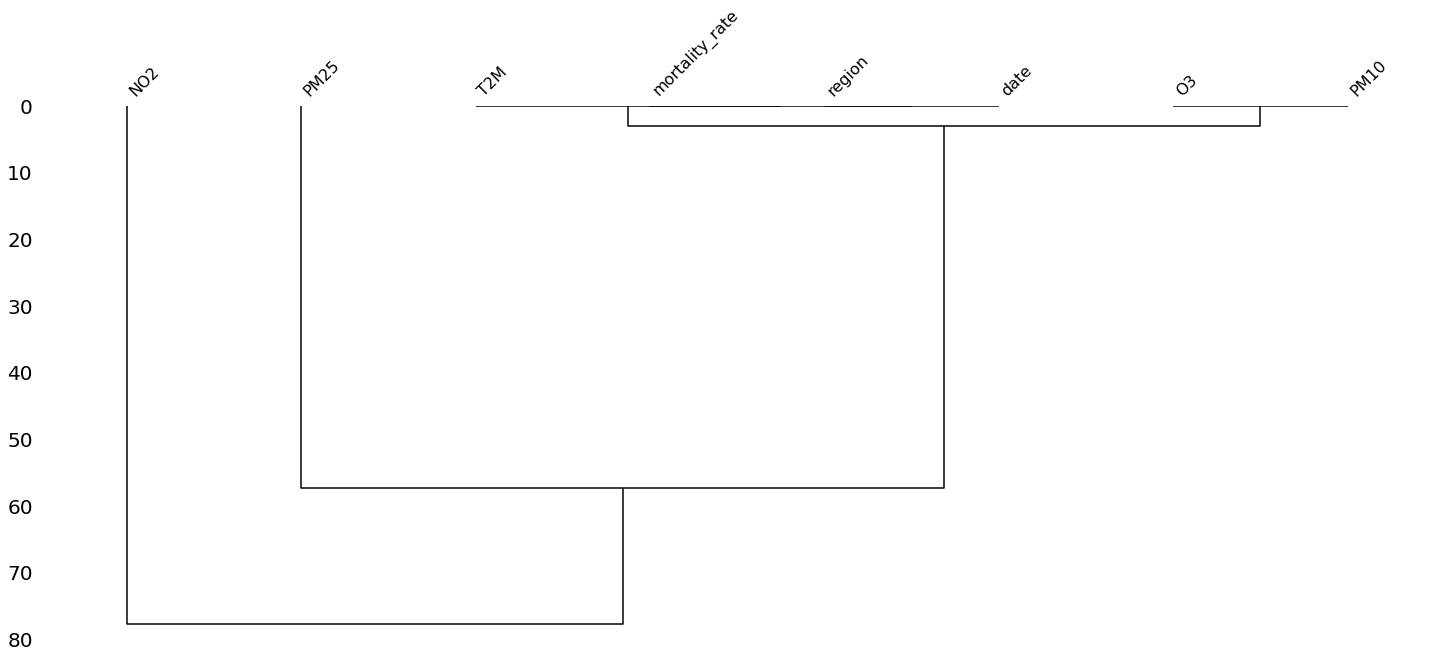

In [479]:
msno.dendrogram(train)

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


37790

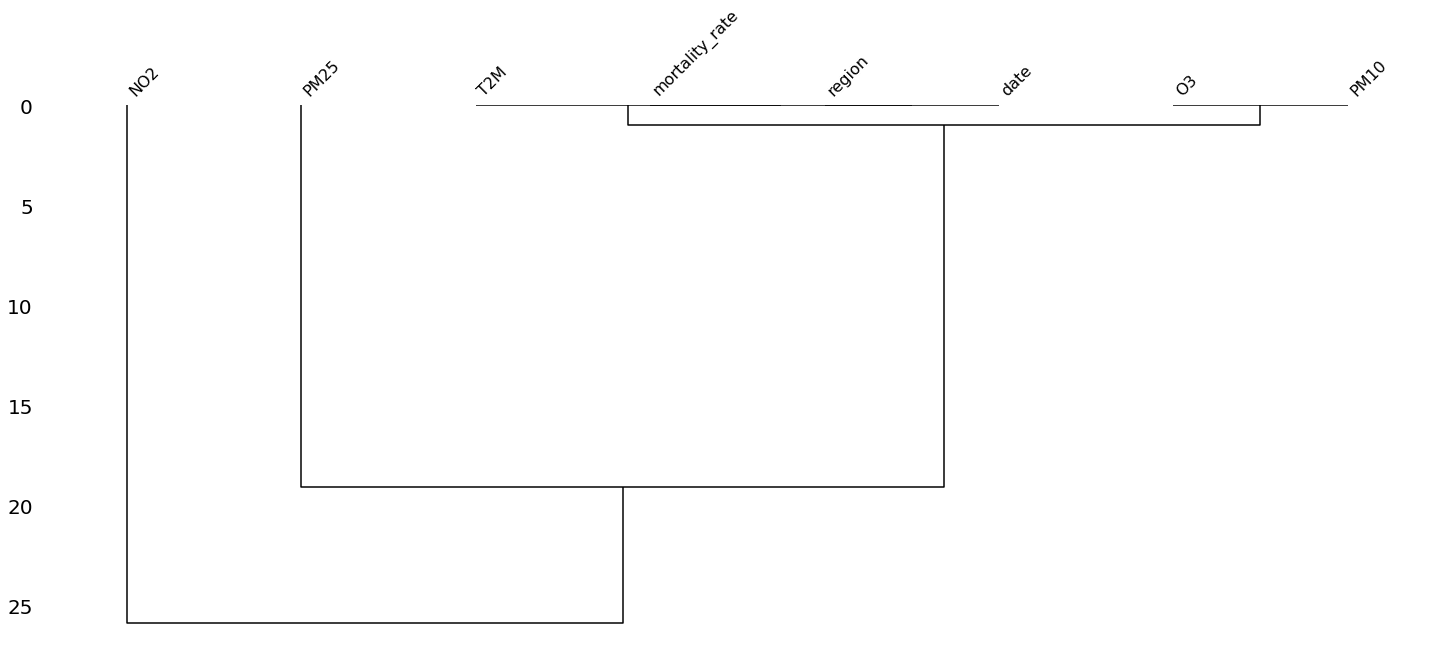

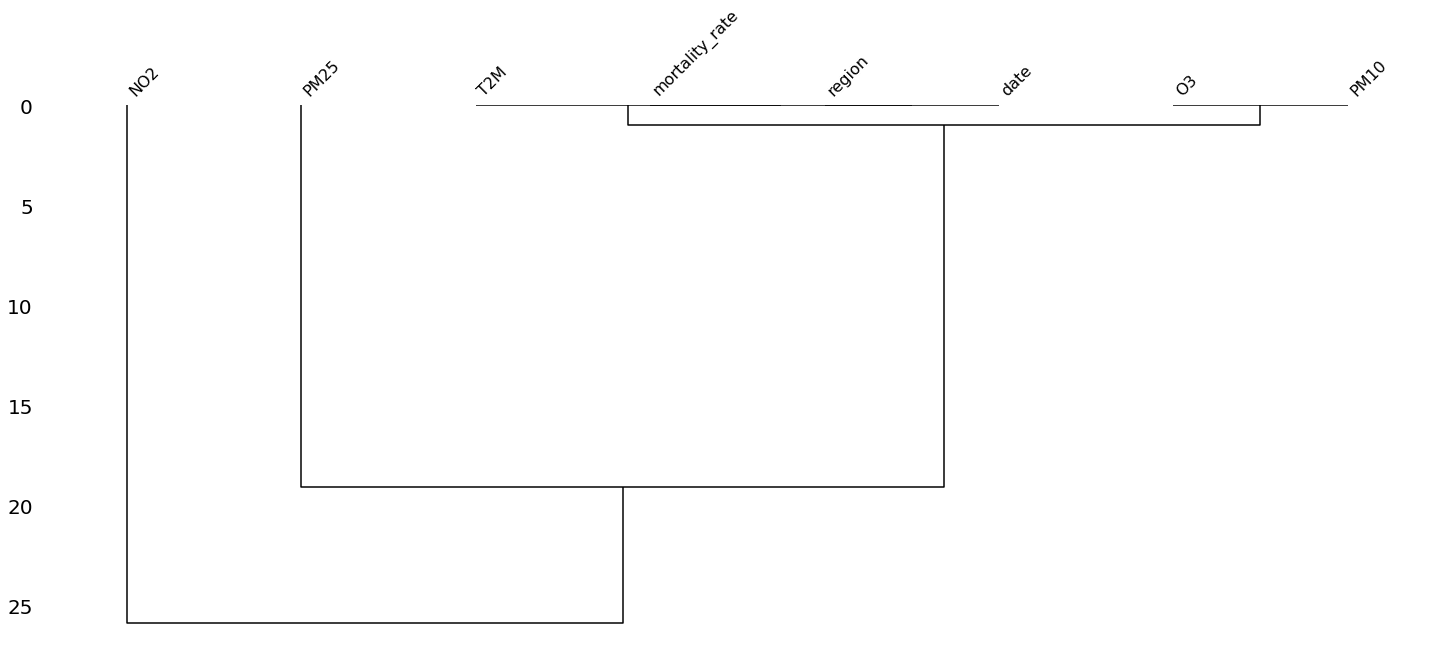

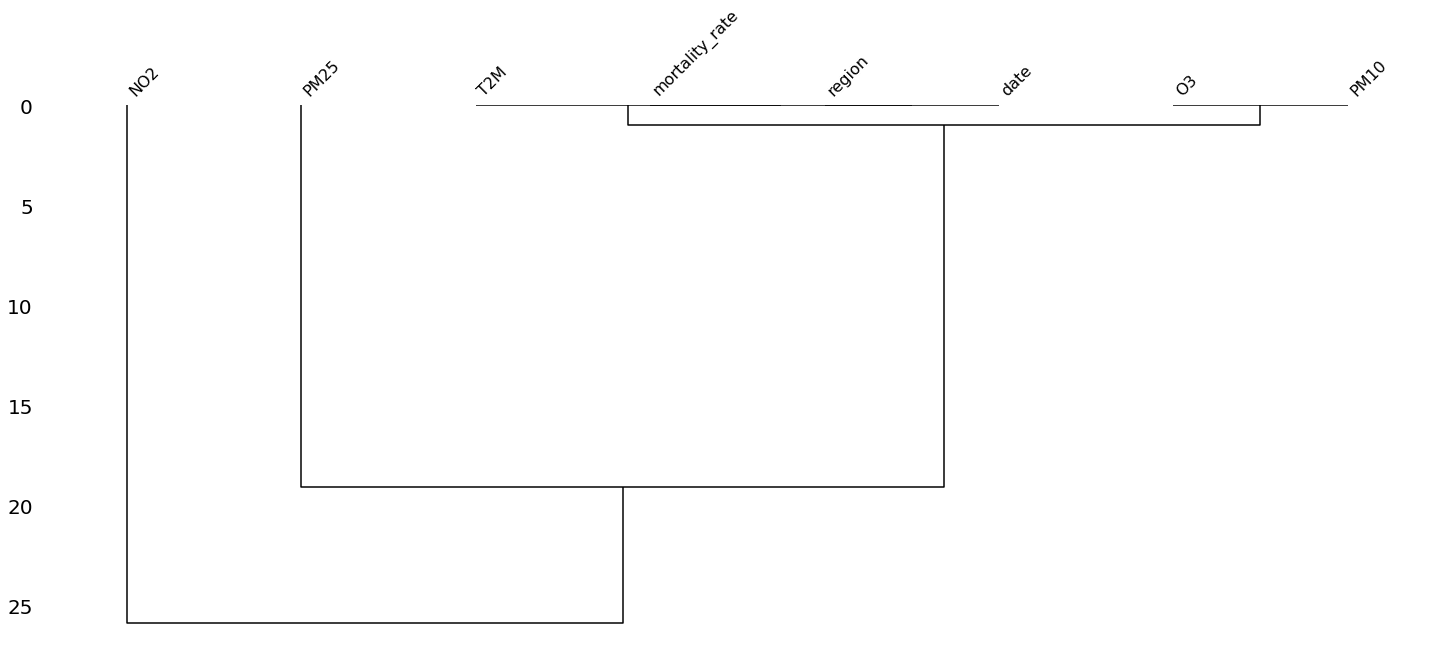

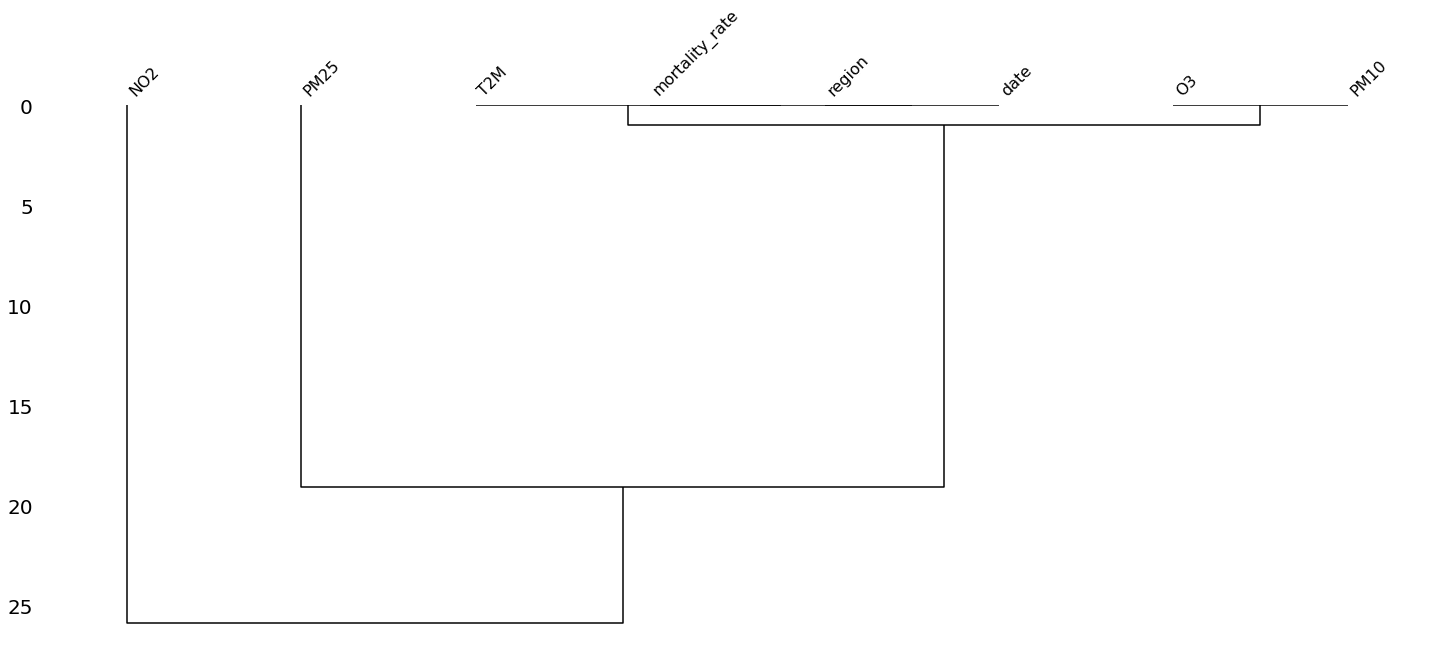

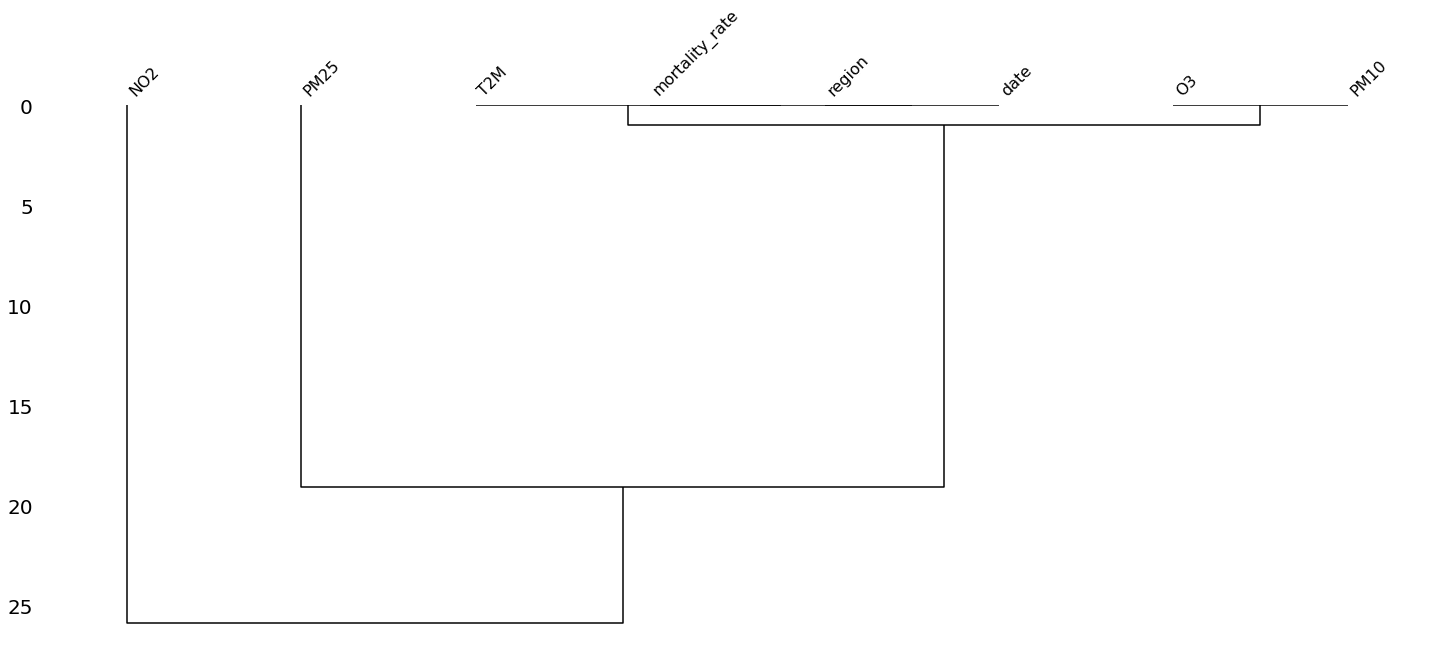

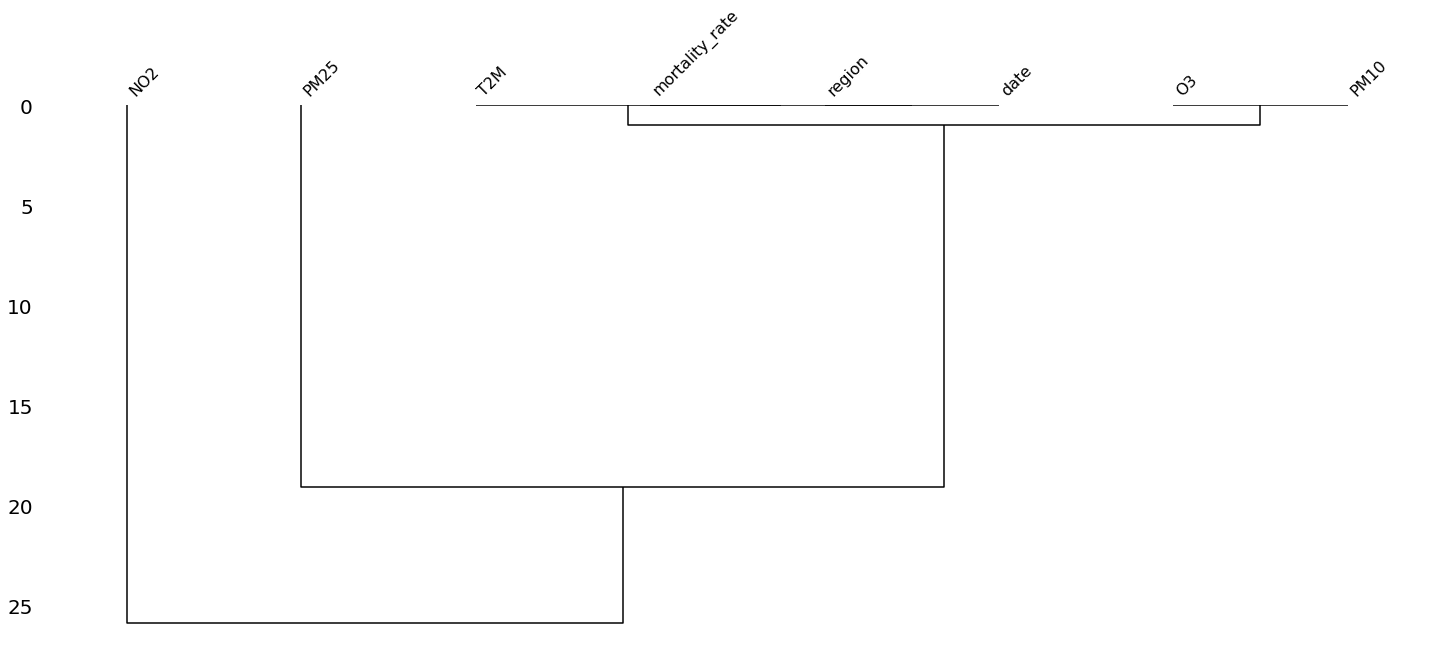

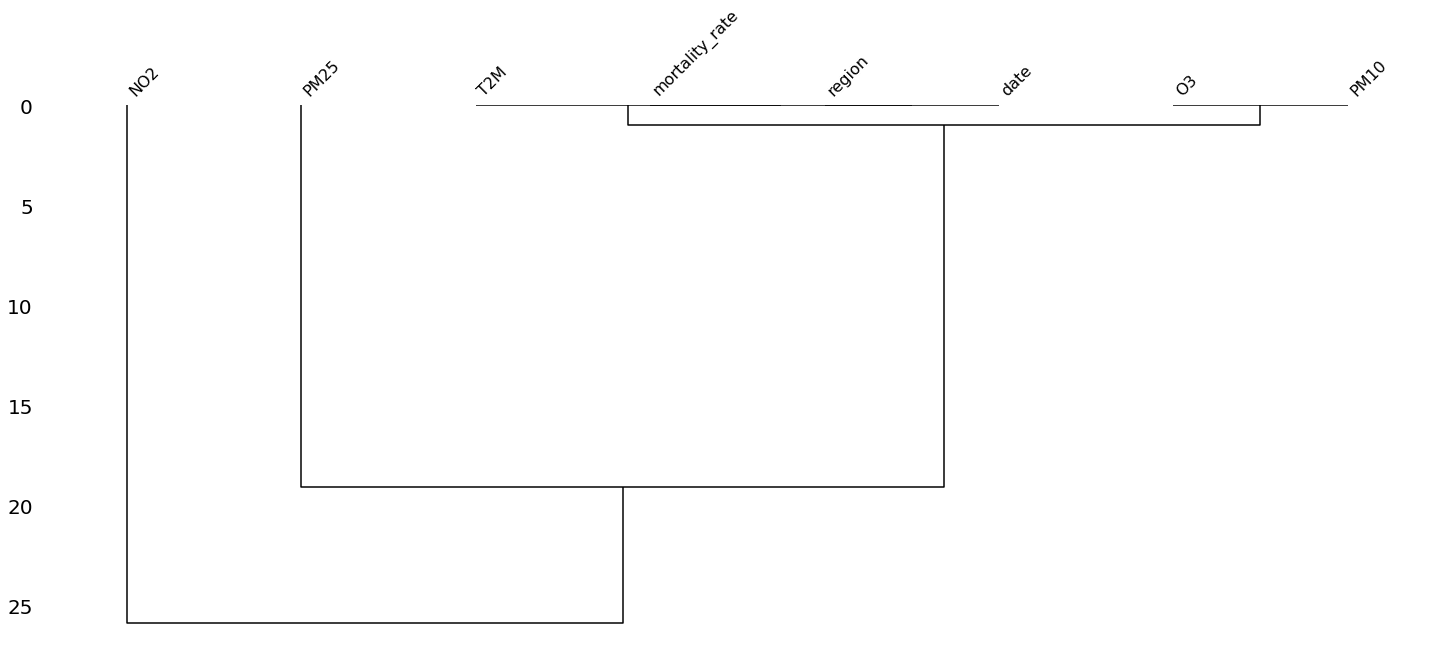

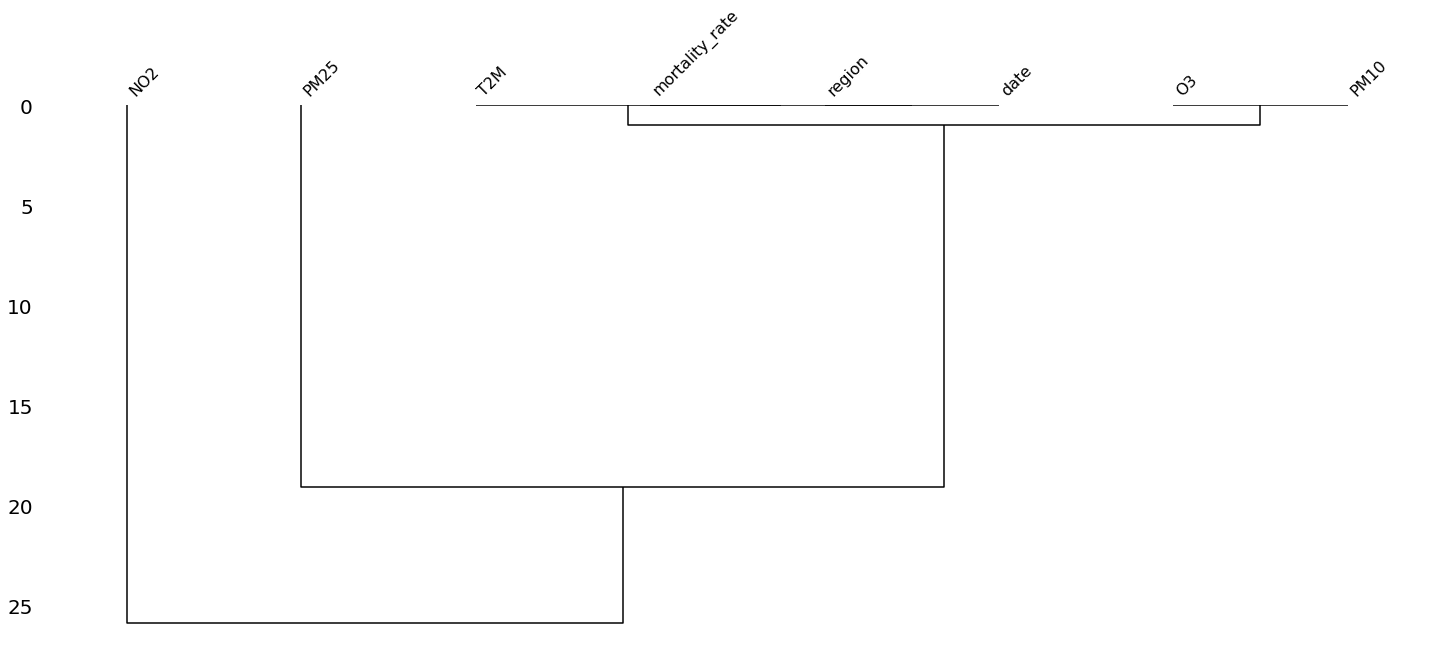

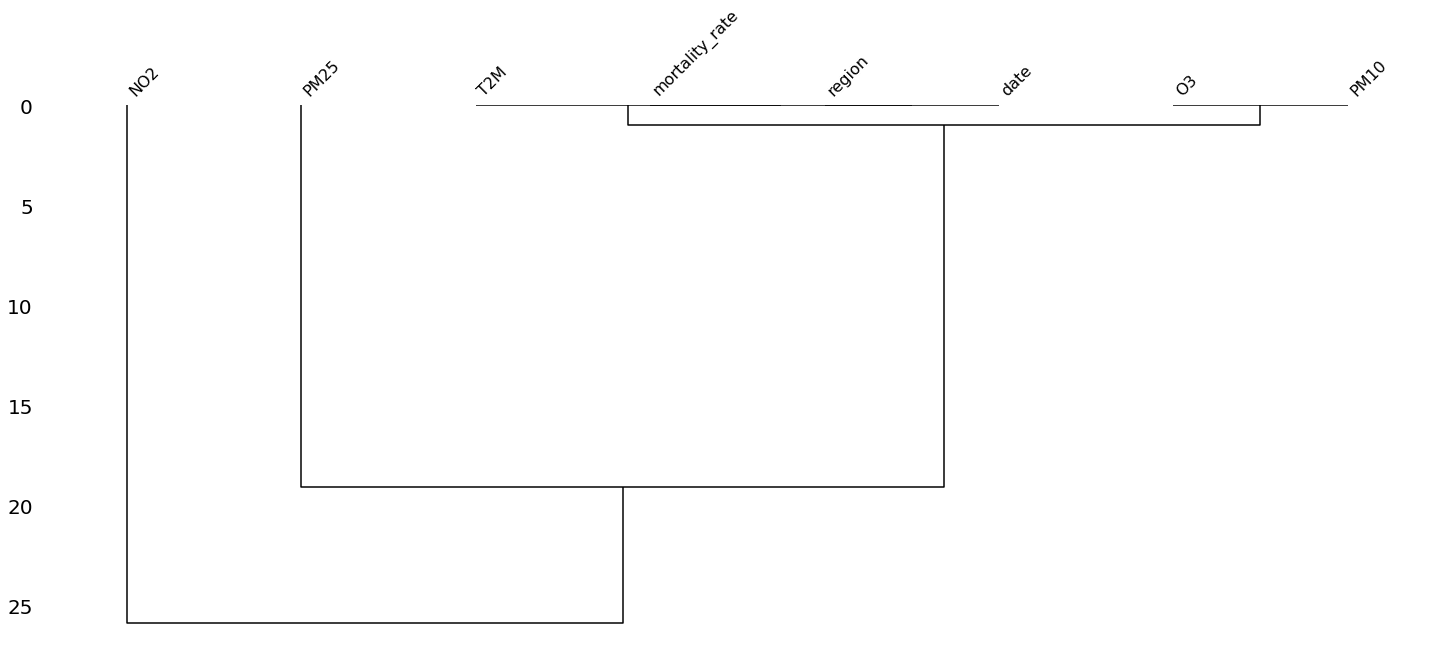

In [481]:
for r in train['region'].unique():
  t = train[train['region']==r]
  print(msno.dendrogram(t))

del t
gc.collect()

**_Missing values present in 4 columns, O3 ,PM10, PM25, NO2_**

## Merging Region names with the rest of the data

In [0]:
train1 = train.merge(region, left_on='region', right_on='Code')
train1.drop(columns = ['region'],inplace=True)
test1 = test.merge(region, left_on='region', right_on='Code')
test1.drop(columns = ['region'],inplace=True)

## univariate analysis ##

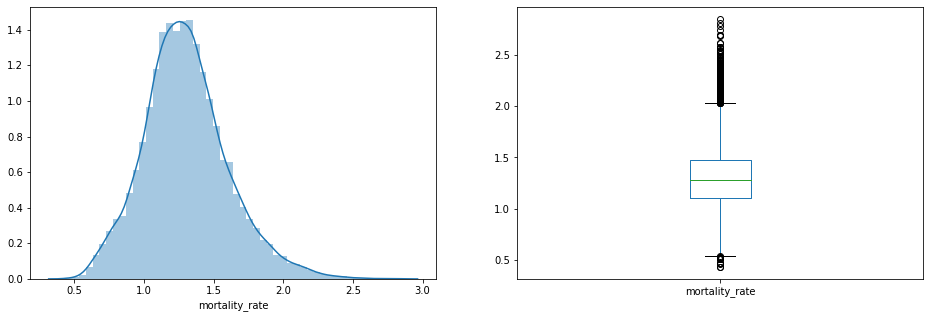

In [484]:
# Visualizing mortality_rate
def mr(df):
  plt.subplot(121)
  sns.distplot(df['mortality_rate']);

  plt.subplot(122)
  df['mortality_rate'].plot.box(figsize=(16,5))

  plt.show()

mr(train)

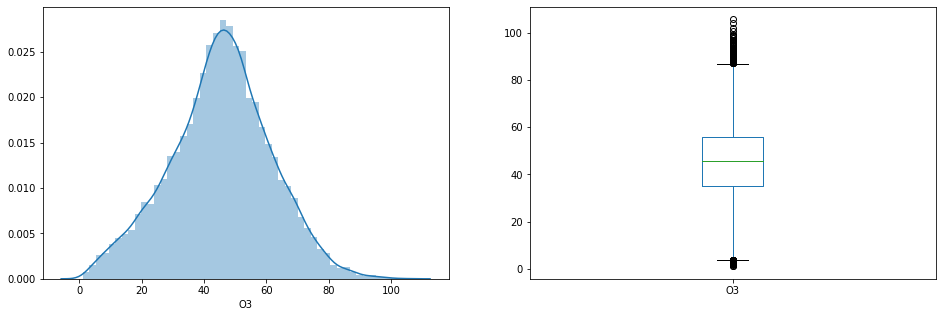

In [486]:
# Visualizing O3
def o3(df):
    plt.subplot(121)
    O3_1 = train['O3'].dropna()
    sns.distplot(O3_1);

    plt.subplot(122)
    O3_1.plot.box(figsize=(16,5))

    plt.show()
    plt.close()

o3(train)

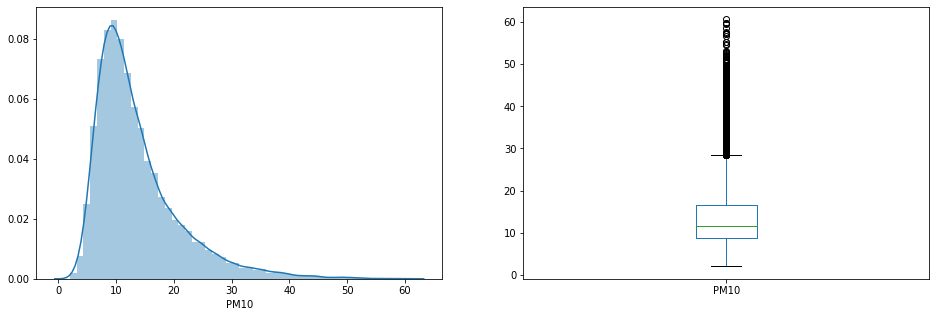

In [487]:
# Visualizing PM10
def pm10(df):
    plt.subplot(121)
    PM10_1 = train['PM10'].dropna()
    sns.distplot(PM10_1);

    plt.subplot(122)
    PM10_1.plot.box(figsize=(16,5))

    plt.show()

pm10(train)

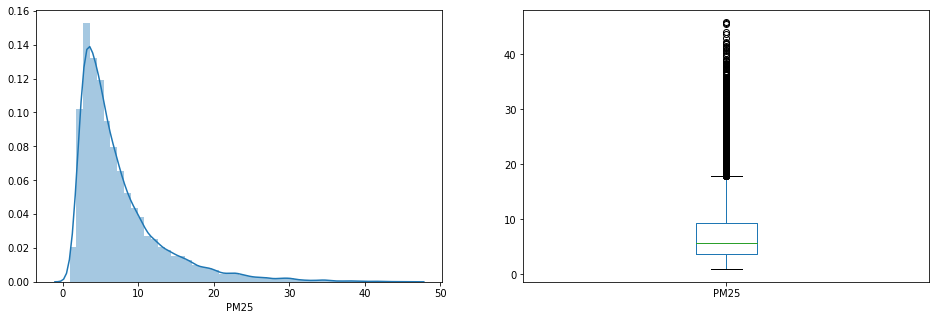

In [488]:
# Visualizing PM25

def pm25(df):
    plt.subplot(121)
    PM25_1 = train['PM25'].dropna()
    sns.distplot(PM25_1);

    plt.subplot(122)
    PM25_1.plot.box(figsize=(16,5))

    plt.show()

pm25(train)

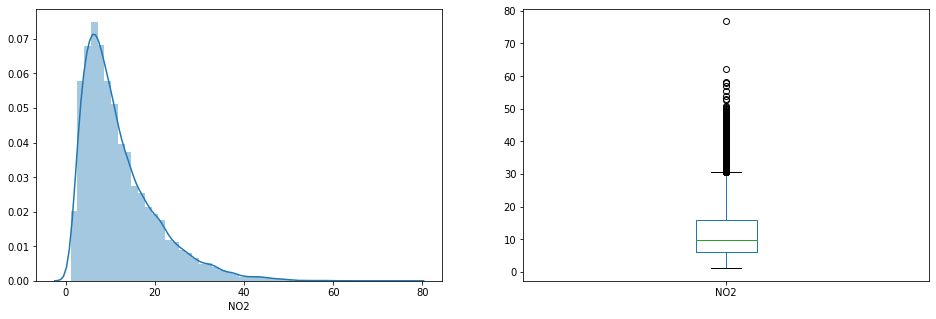

In [489]:
# Visualizing NO2
def no2(df):
    plt.subplot(121)
    NO2_1 = train['NO2'].dropna()
    sns.distplot(NO2_1);

    plt.subplot(122)
    NO2_1.plot.box(figsize=(16,5))

    plt.show()
  
no2(train)

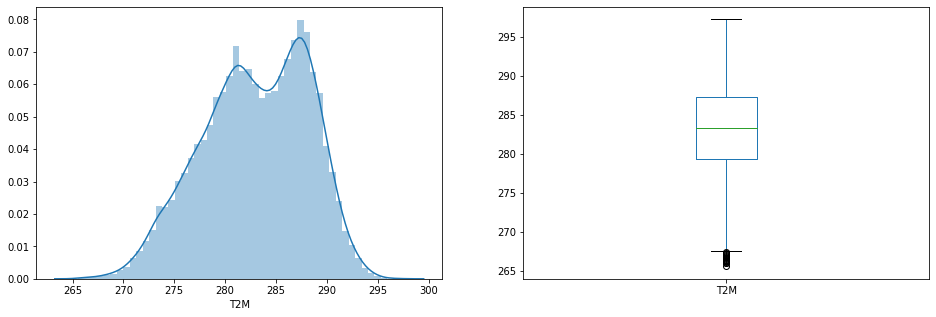

In [490]:
# Visualizing T2M

def t2m(df):
    plt.subplot(121)
    sns.distplot(train['T2M']);

    plt.subplot(122)
    train['T2M'].plot.box(figsize=(16,5))

    plt.show()

t2m(train)

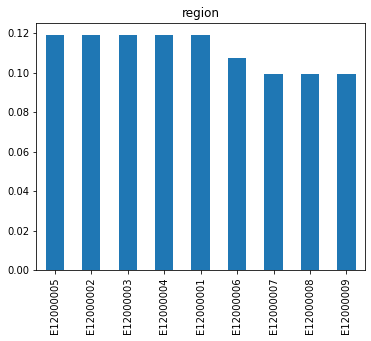

In [358]:
# Visualizing categorical features
plt.subplot(231)
train['region'].value_counts(normalize=True).plot.bar(figsize=(20,10), title= 'region')

mortality rate across regions


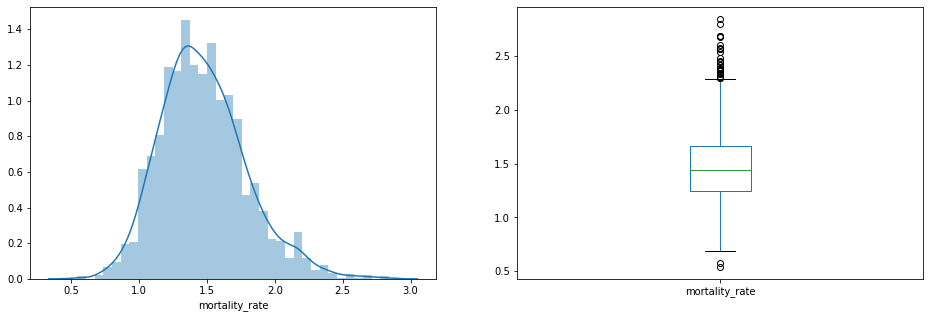

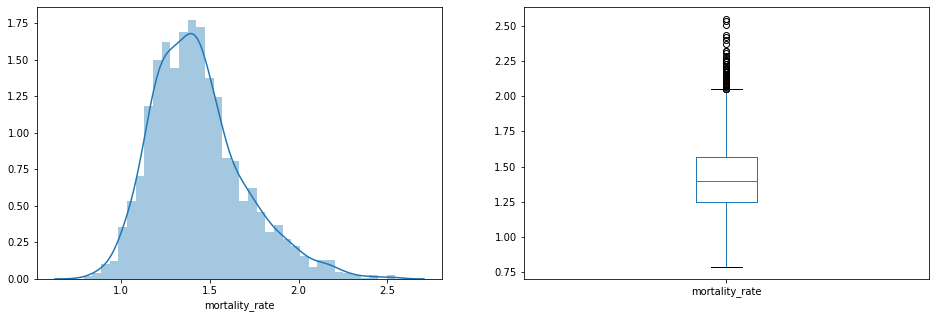

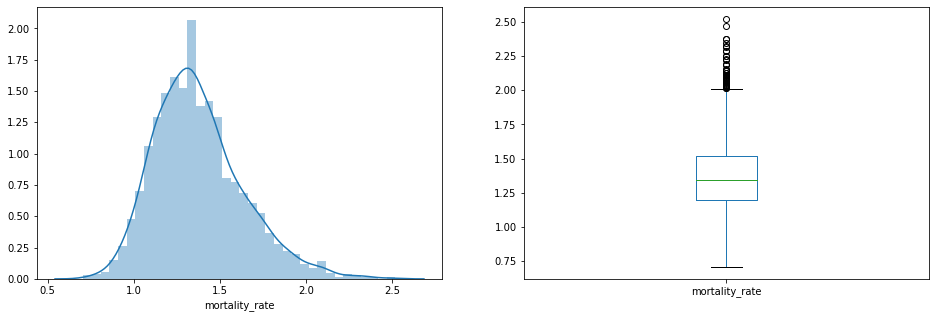

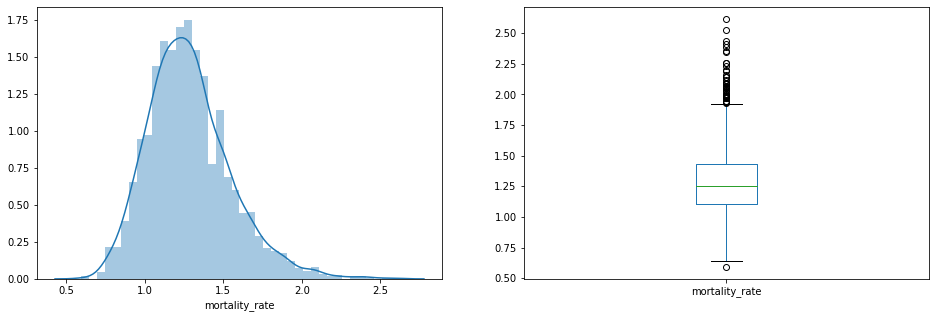

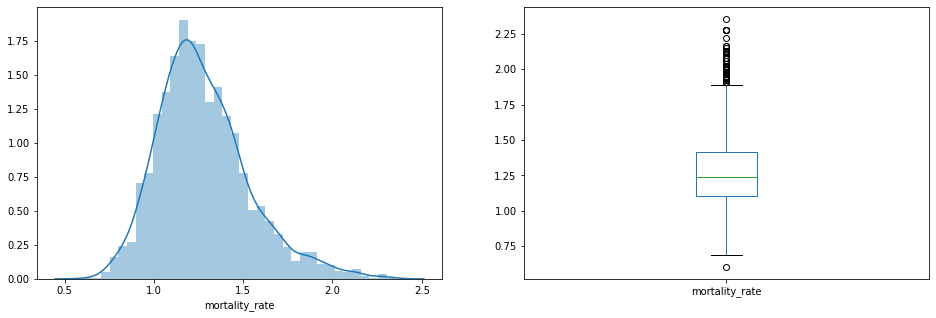

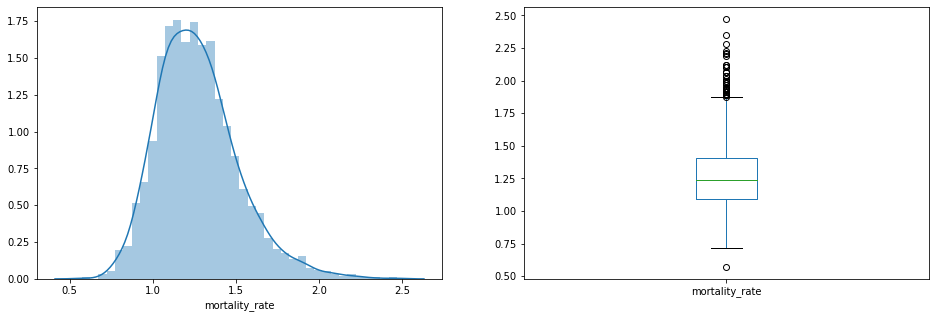

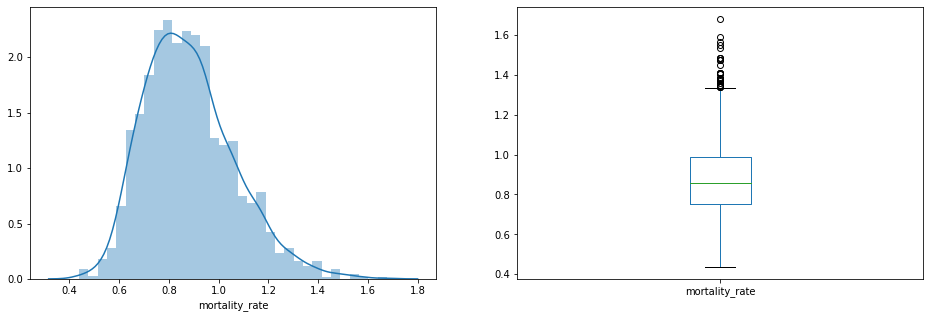

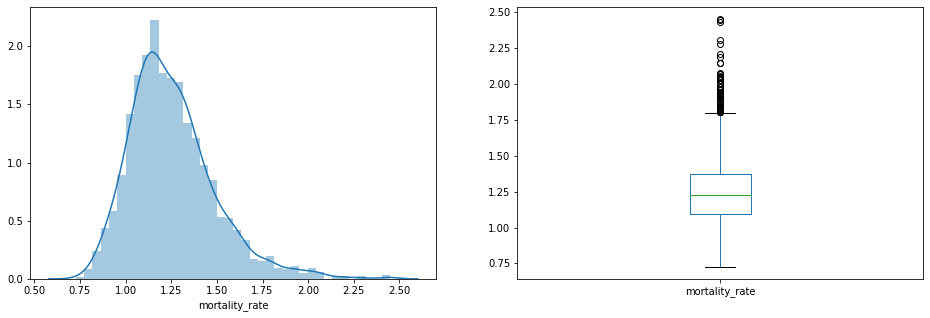

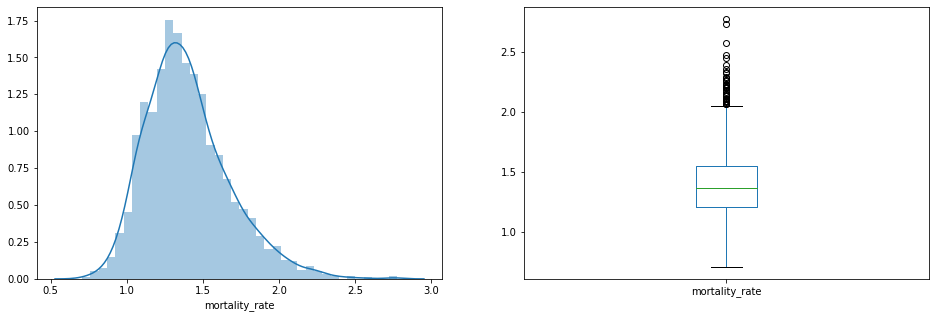

In [498]:
print('mortality rate across regions')
for r in train['region'].unique():
  t = train[train['region']==r]
  mr(t)

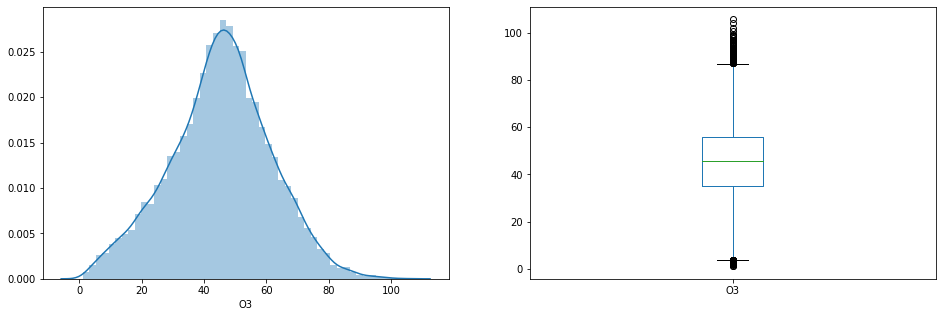

None


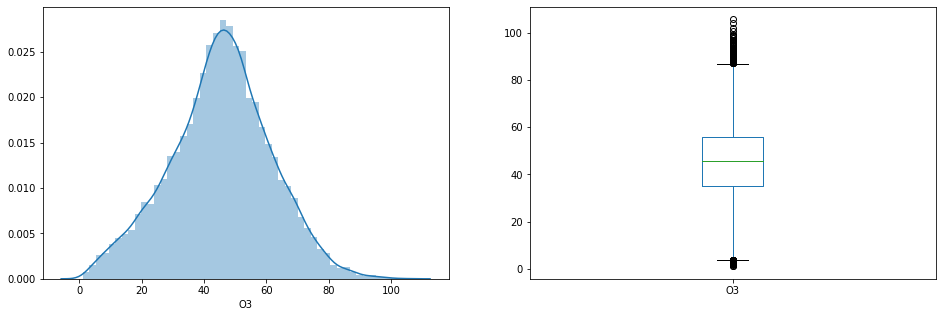

None


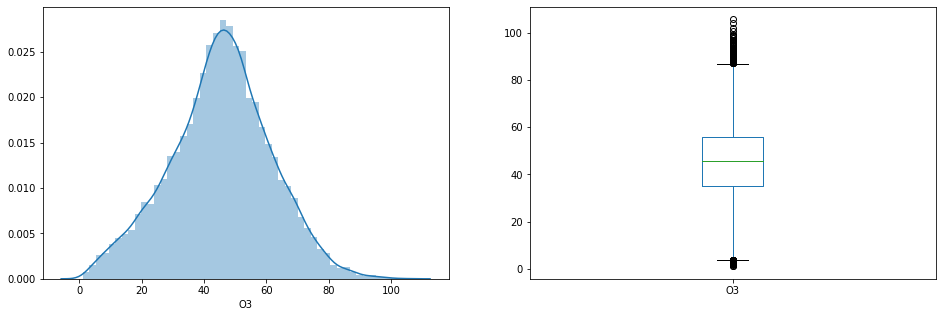

None


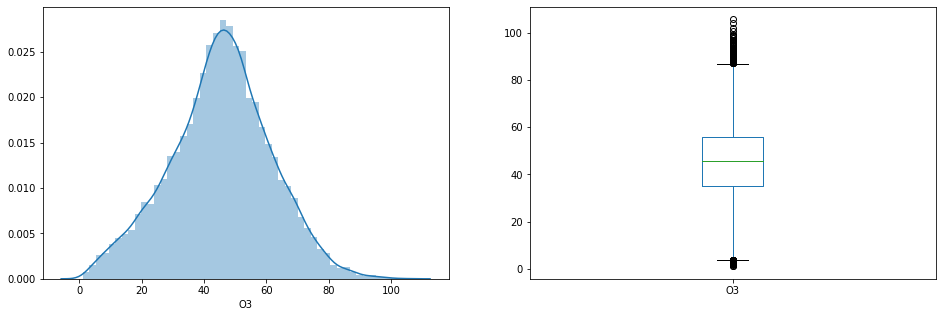

None


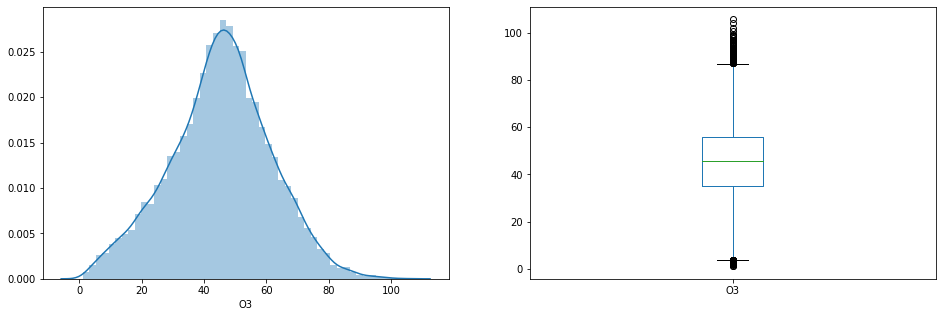

None


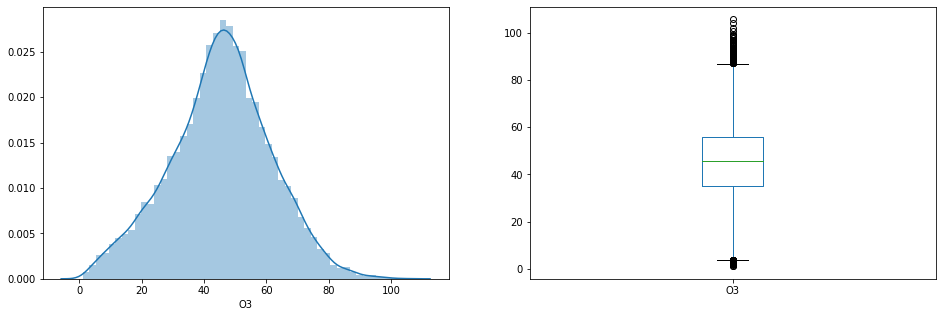

None


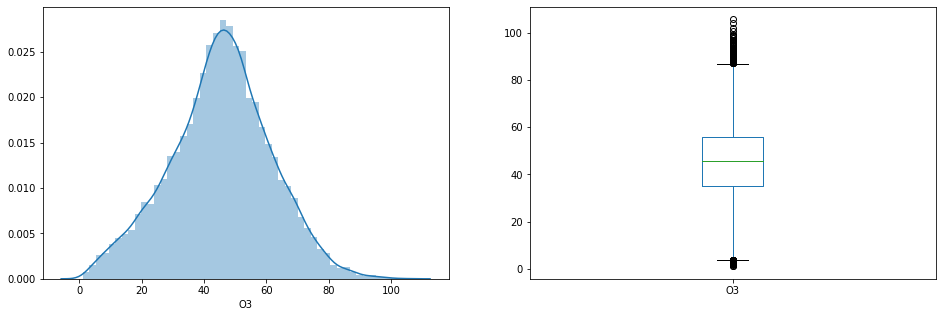

None


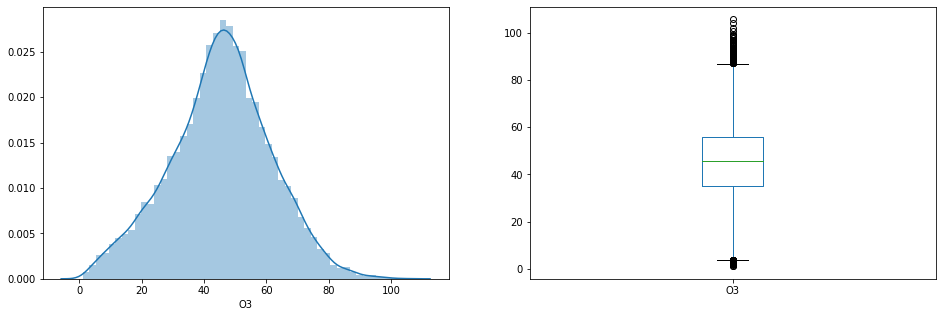

None


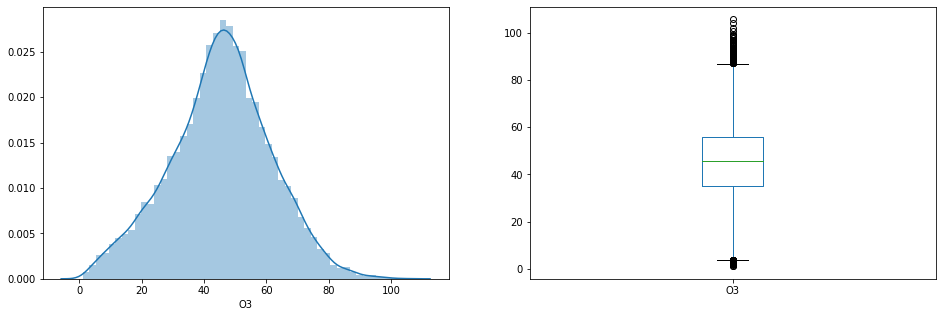

None


In [492]:
for r in train['region'].unique():
  t = train[train['region']==r]
  print(o3(t))

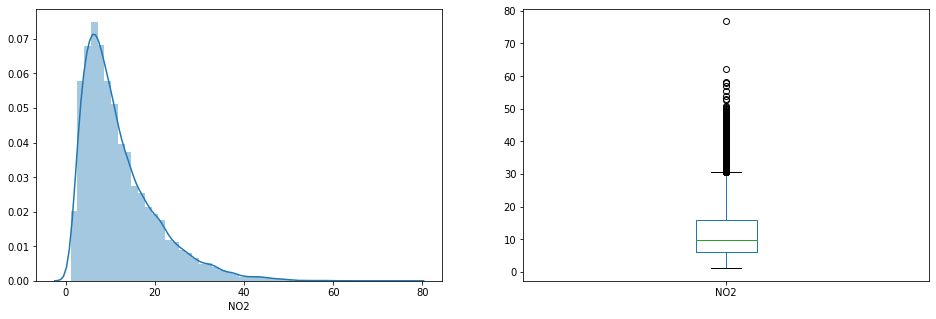

None


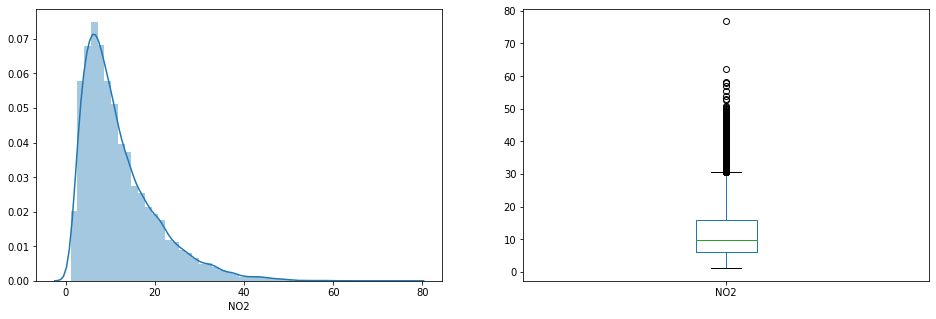

None


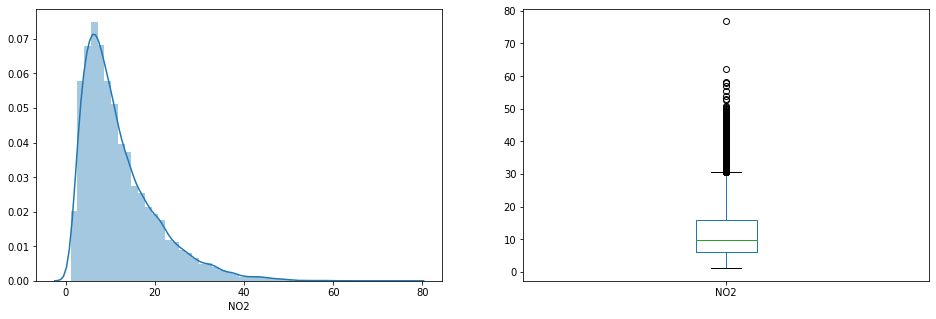

None


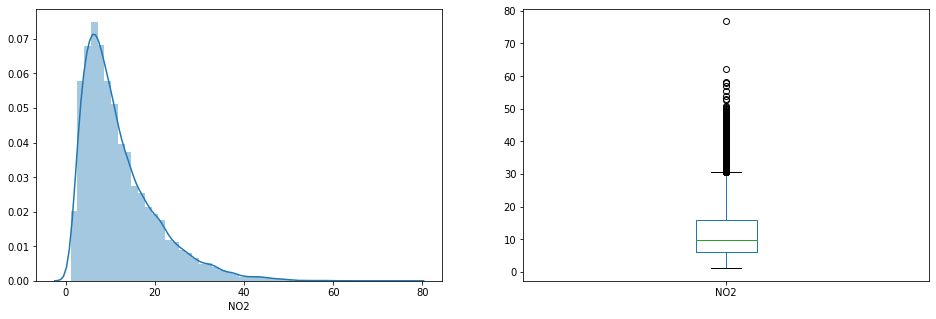

None


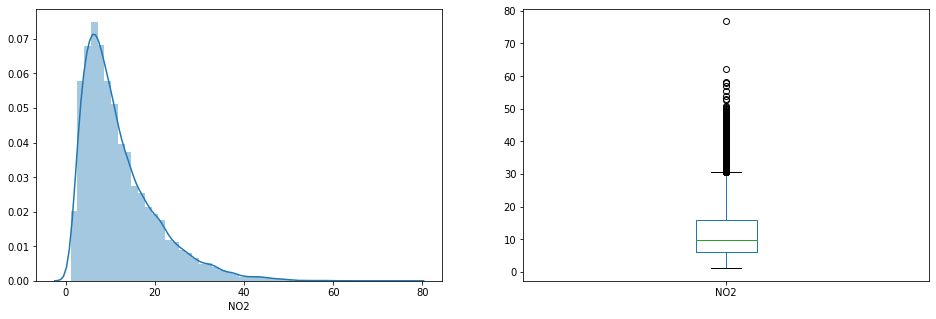

None


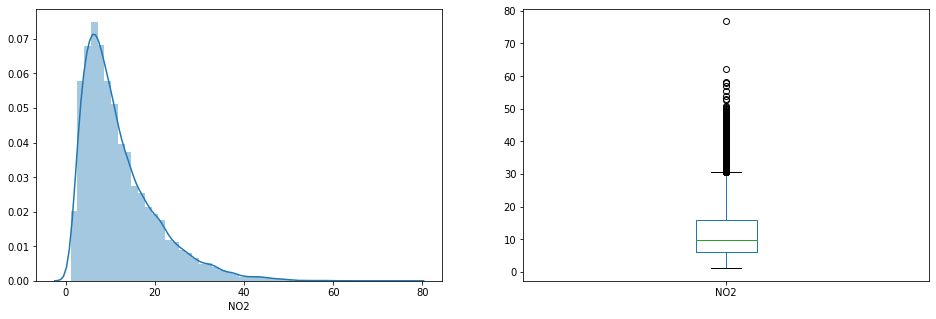

None


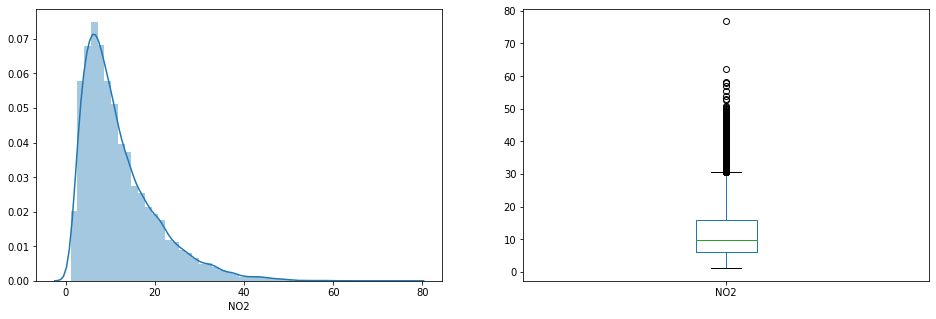

None


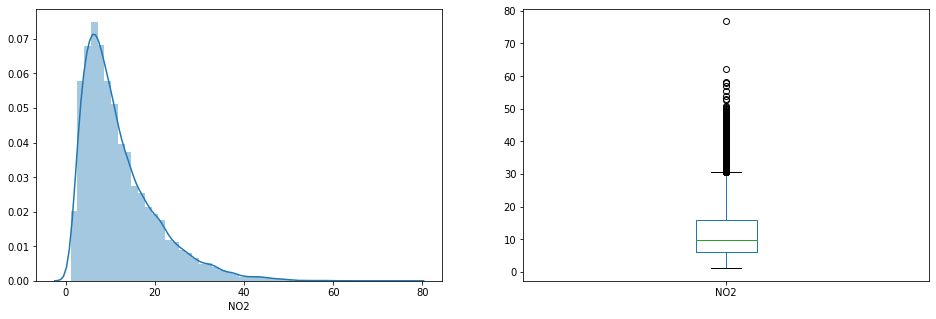

None


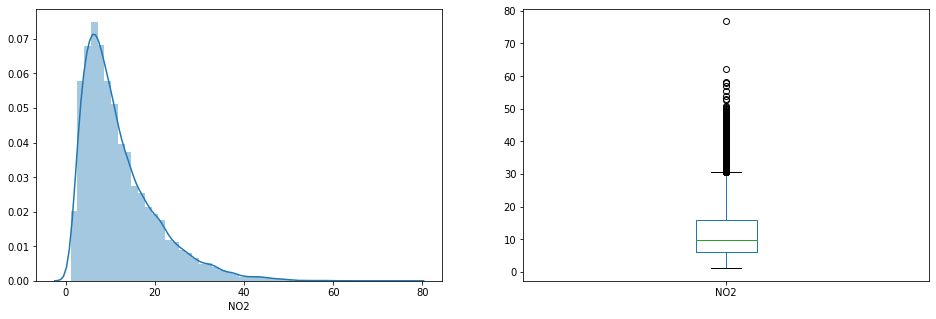

None


In [493]:
for r in train['region'].unique():
  t = train[train['region']==r]
  print(no2(t))

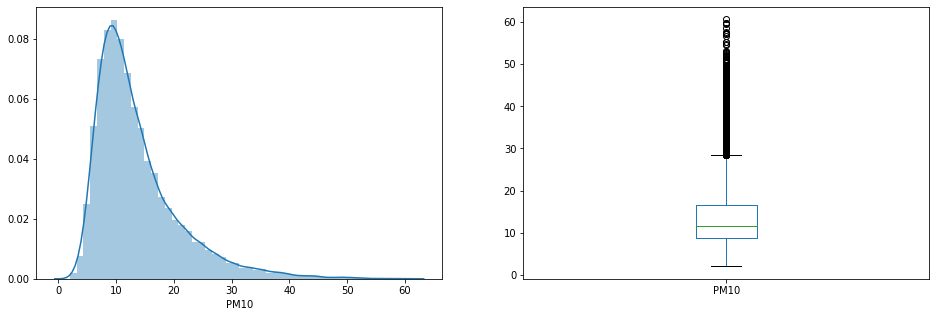

None


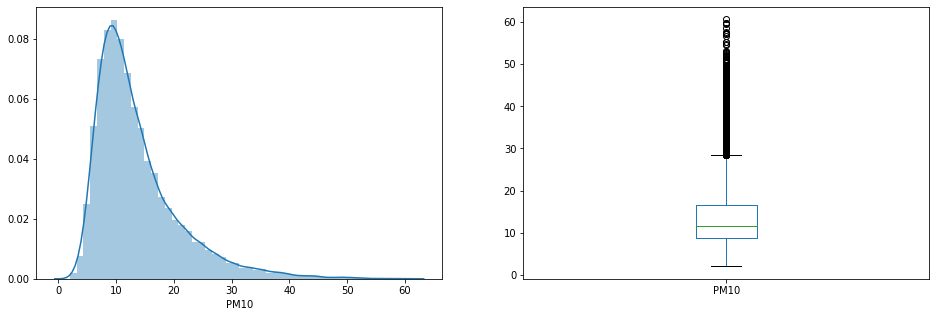

None


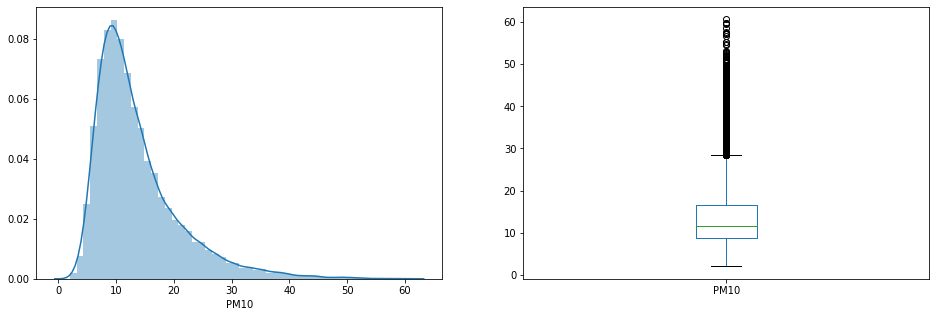

None


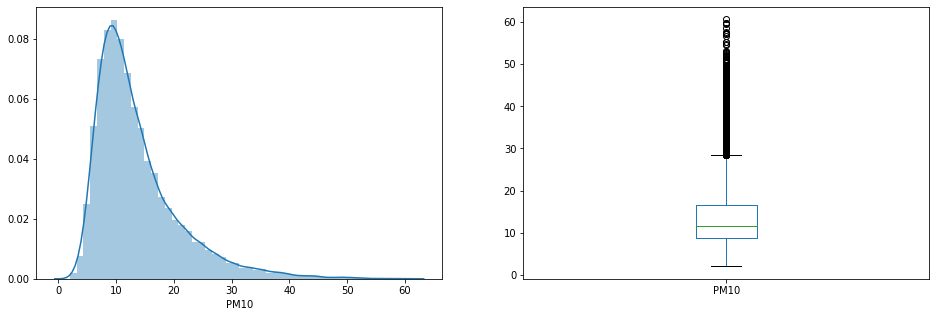

None


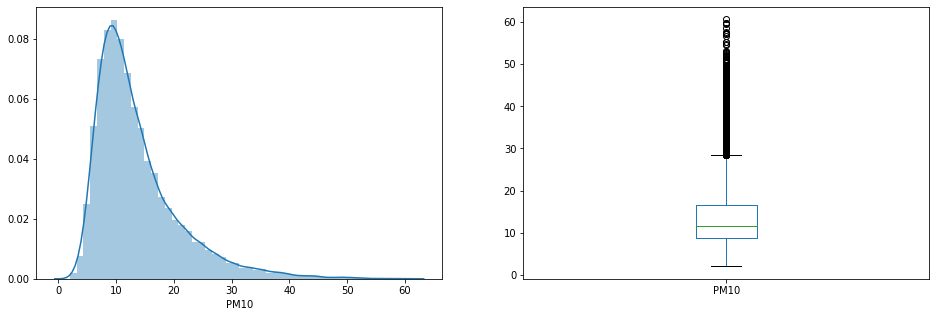

None


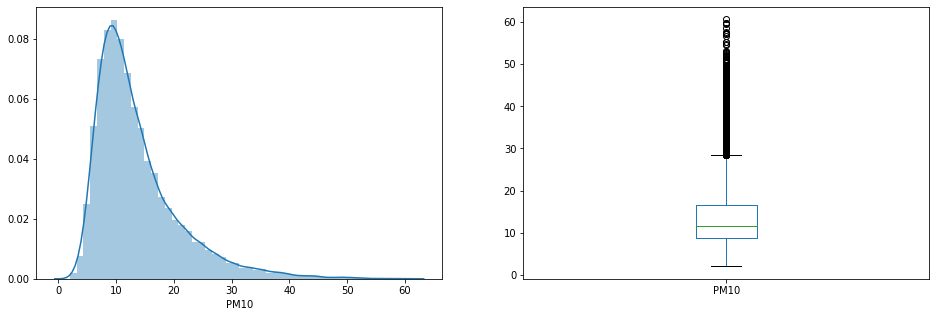

None


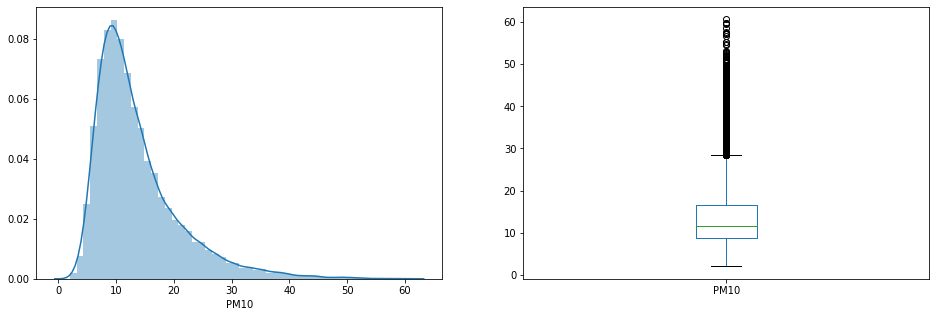

None


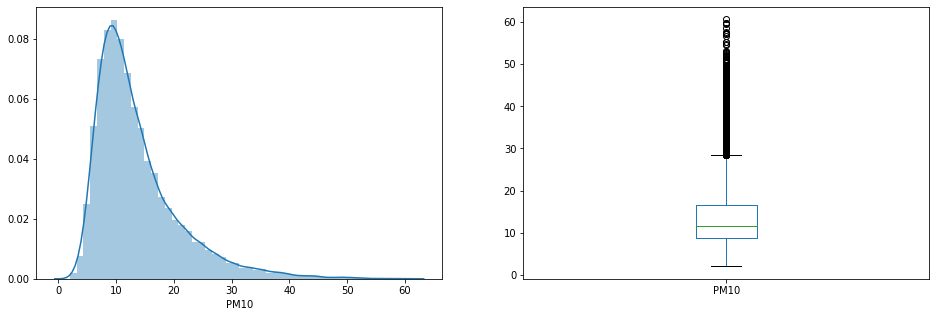

None


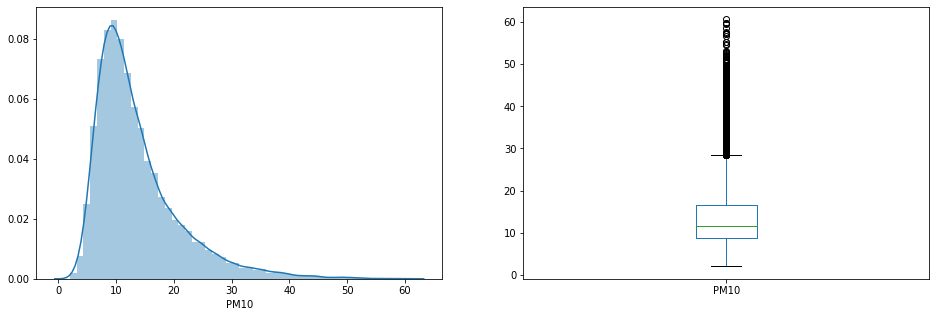

None


In [494]:
for r in train['region'].unique():
  t = train[train['region']==r]
  print(pm10(t))

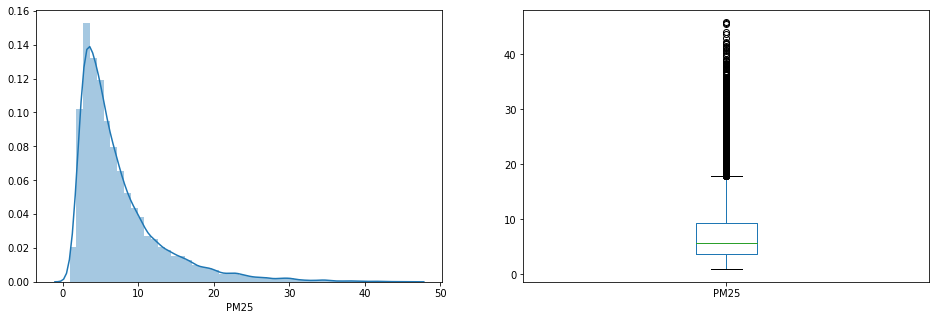

None


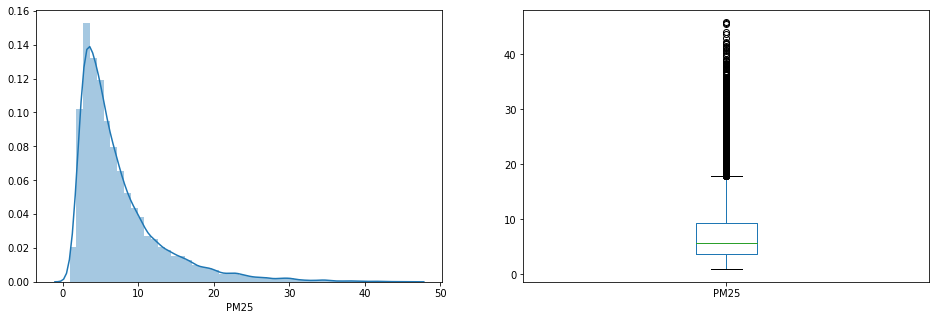

None


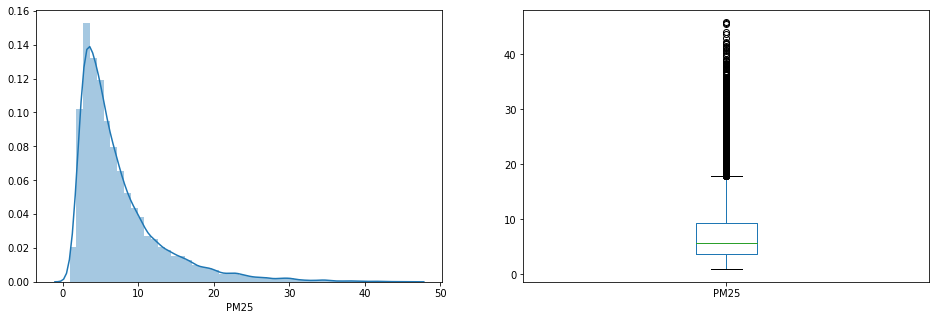

None


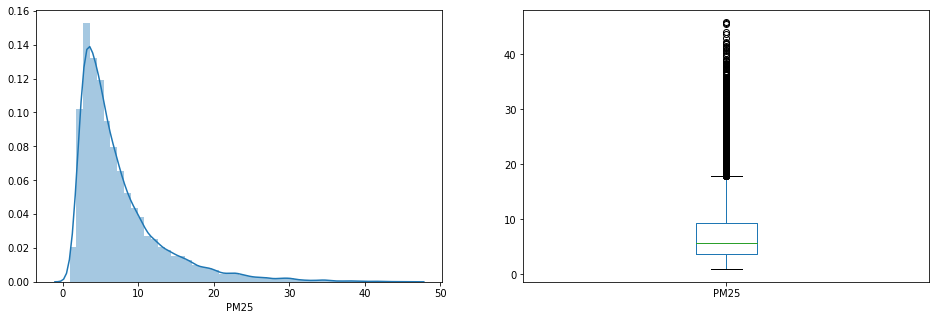

None


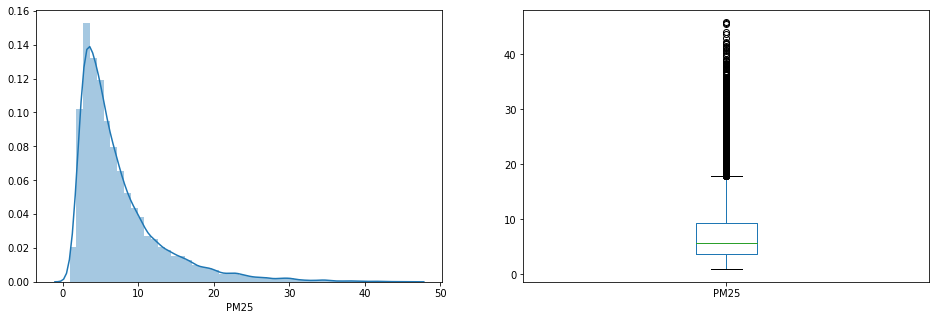

None


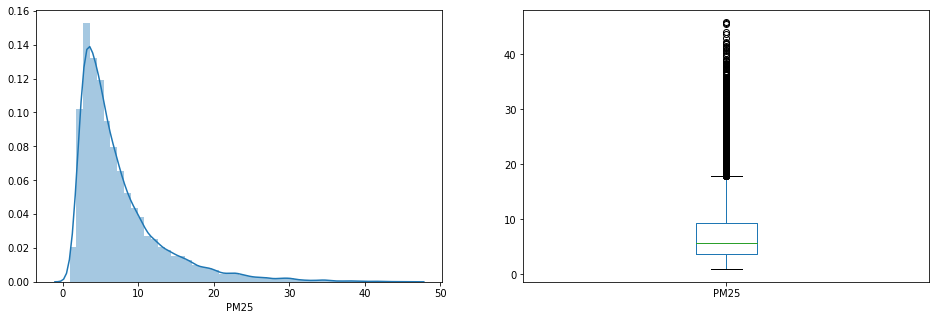

None


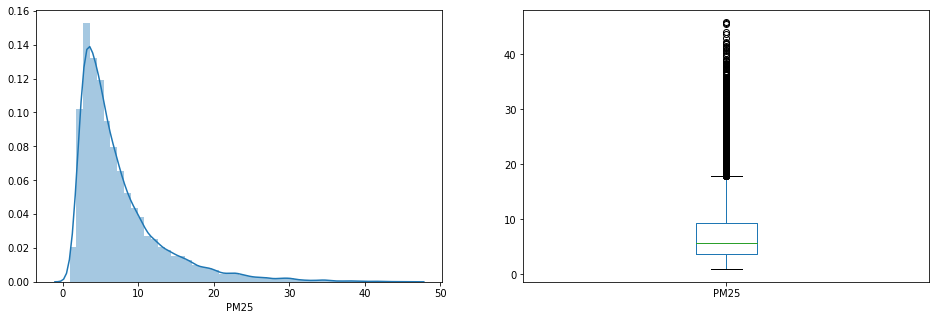

None


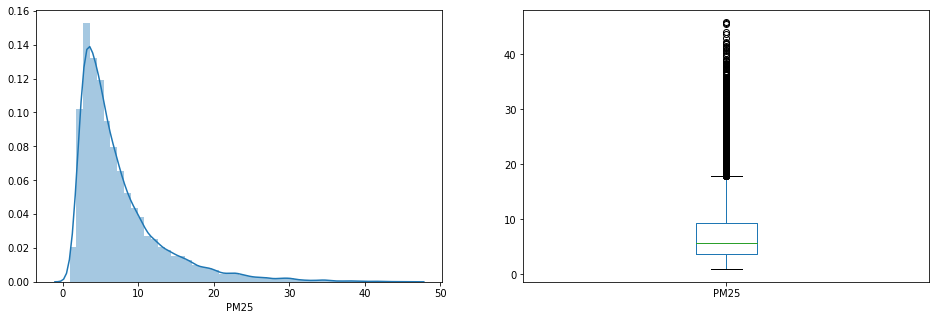

None


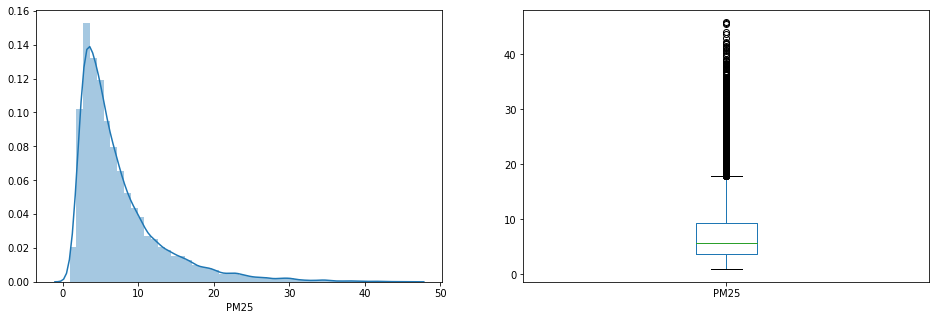

None


In [495]:
for r in train['region'].unique():
  t = train[train['region']==r]
  print(pm25(t))

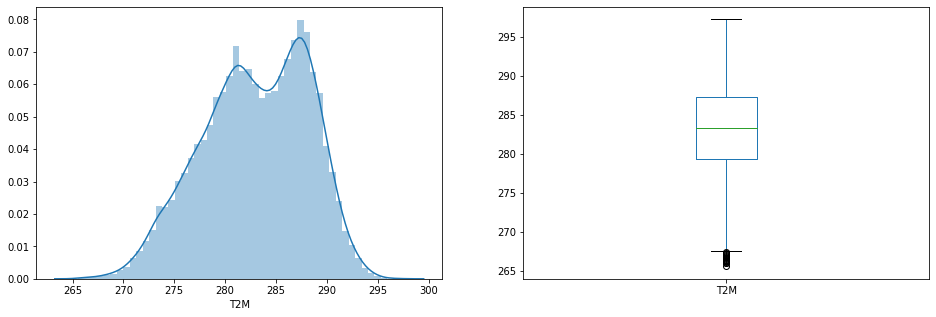

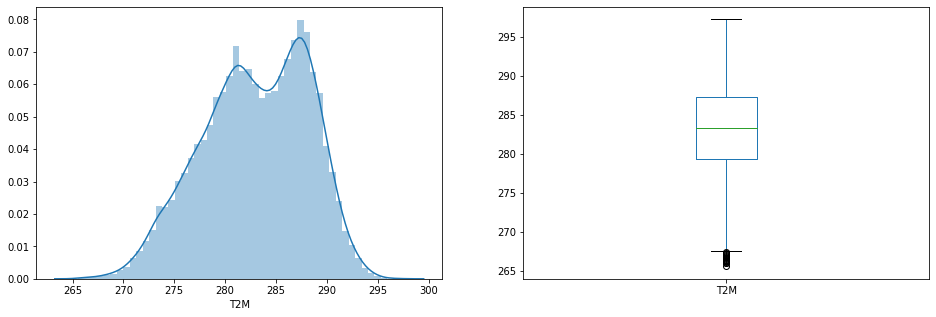

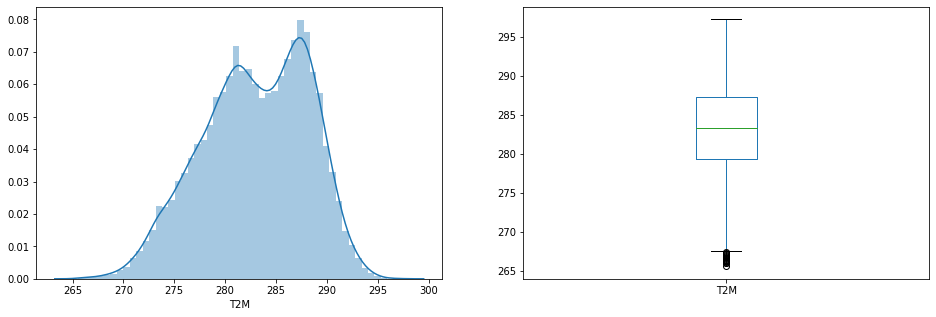

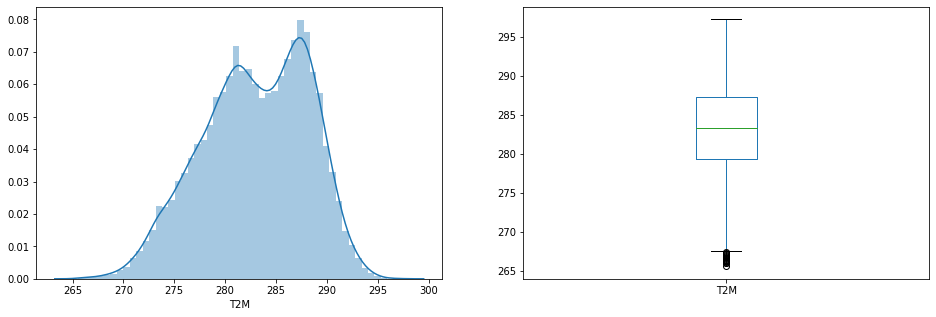

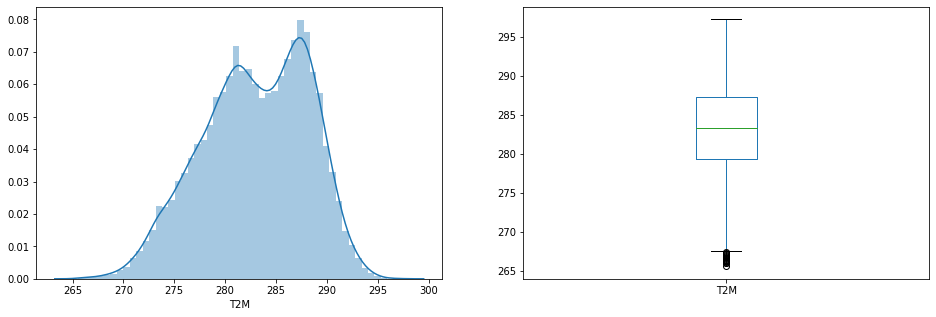

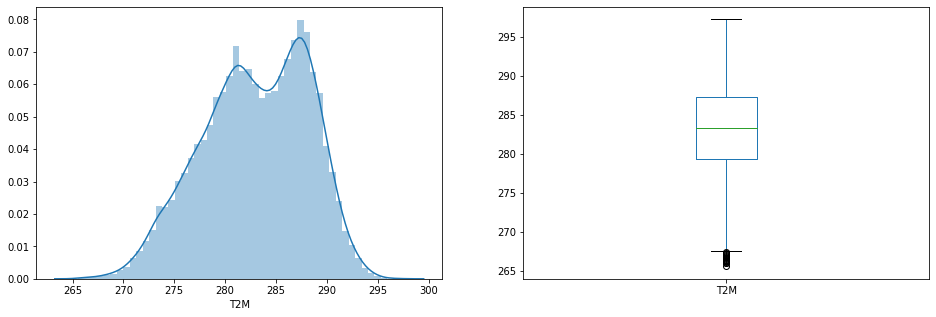

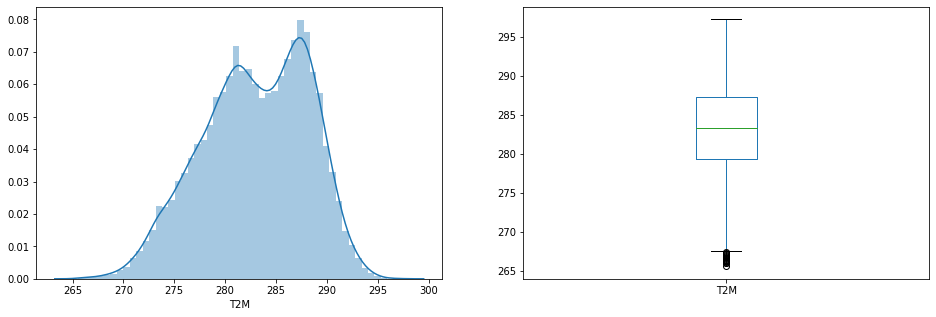

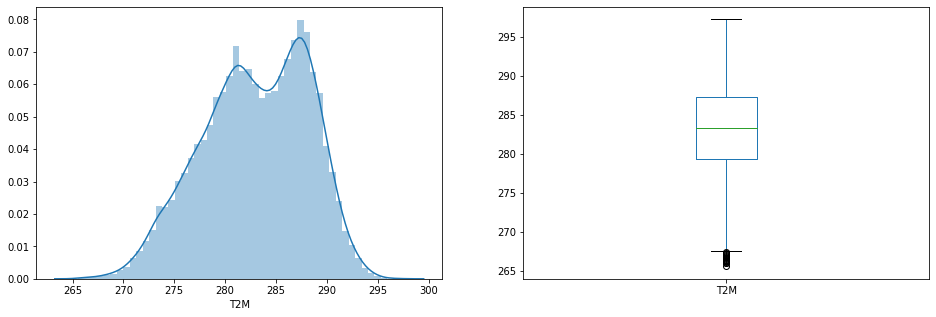

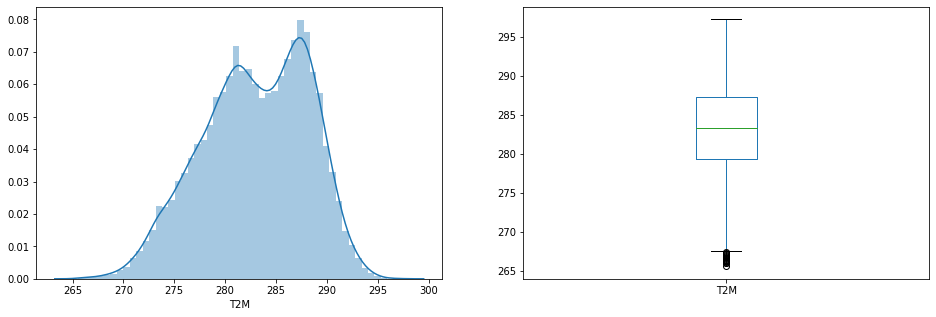

In [497]:
for r in train['region'].unique():
  t = train[train['region']==r]
  t2m(t)

In [0]:
#train1.groupby("region")["Region"].unique()

In [360]:
train1.head()

,region,date,mortality_rate,O3,PM10,PM25,NO2,T2M,Code,Region
0,E12000001,2007-01-02,2.264,42.358,9.021,NaN,NaN,278.138,E12000001,North East
1,E12000001,2007-01-03,2.030,49.506,5.256,NaN,NaN,281.745,E12000001,North East
2,E12000001,2007-01-04,1.874,51.101,4.946,NaN,NaN,280.523,E12000001,North East
3,E12000001,2007-01-05,2.069,47.478,6.823,NaN,NaN,280.421,E12000001,North East
4,E12000001,2007-01-06,1.913,45.226,7.532,NaN,NaN,278.961,E12000001,North East


## Transformations

# Bivariate analysis - Region Wise

### variation with date - time series plot ##

### For region 1 - North East

In [499]:
train_r1 = train1[train1["Region"]=="North East"]
fig1 = px.line(train_r1, x='date', y='mortality_rate')
fig1.show()

In [500]:
fig2 = go.Figure([go.Scatter(x=train_r1['date'], y=train_r1['mortality_rate'])])
#fig2.show()

fig2.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)

In [501]:
fig3 = go.Figure([go.Scatter(x=train_r1['date'], y=train_r1["O3"])])
#fig2.show()

fig3.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)

In [502]:
fig2 = go.Figure([go.Scatter(x=train_r1['date'], y=train_r1["PM10"])])
#fig2.show()

fig2.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)

In [503]:
fig4 = go.Figure([go.Scatter(x=train_r1['date'], y=train_r1["PM25"])])
#fig2.show()

fig4.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)

In [504]:
fig5 = go.Figure([go.Scatter(x=train_r1['date'], y=train_r1["NO2"])])
#fig2.show()

fig5.update_layout(title_text='Time Series with Rangeslider',
                  xaxis_rangeslider_visible=True)

### scatter plot of PM25 with other varibles ###

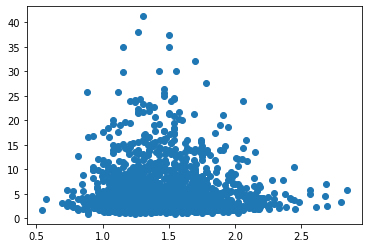

In [506]:
plt.scatter(x=train_r1['mortality_rate'], y=train_r1["PM25"])

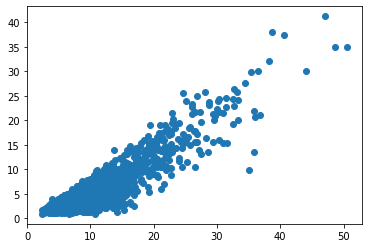

In [507]:
plt.scatter(x=train_r1['PM10'], y=train_r1["PM25"])

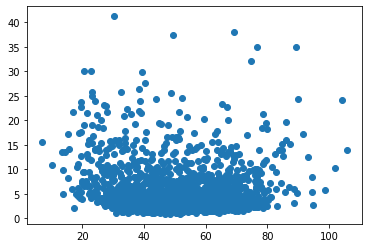

In [508]:
plt.scatter(x=train_r1['O3'], y=train_r1["PM25"])

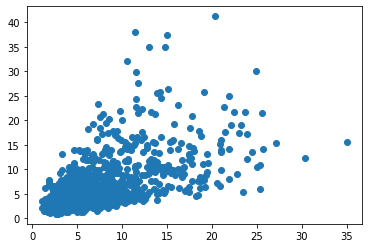

In [509]:
plt.scatter(x=train_r1['NO2'], y=train_r1["PM25"])

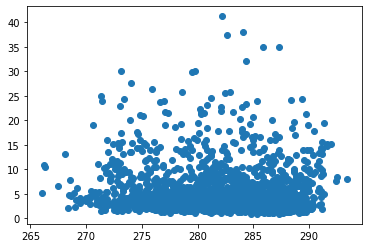

In [510]:
plt.scatter(x=train_r1['T2M'], y=train_r1["PM25"])

### scatter plot of NO2 with other variables ###

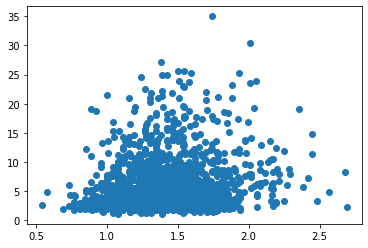

In [511]:
plt.scatter(x=train_r1['mortality_rate'], y=train_r1["NO2"])

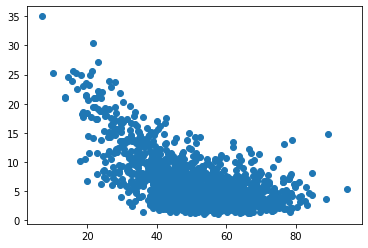

In [512]:
plt.scatter(x=train_r1['O3'], y=train_r1["NO2"])

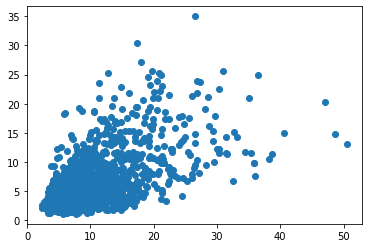

In [513]:
plt.scatter(x=train_r1['PM10'], y=train_r1["NO2"])

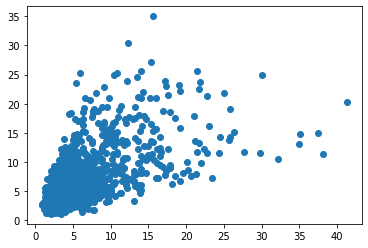

In [514]:
plt.scatter(x=train_r1['PM25'], y=train_r1["NO2"])

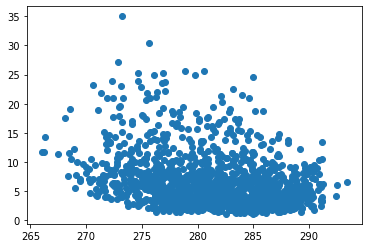

In [515]:
plt.scatter(x=train_r1['T2M'], y=train_r1["NO2"])

## Missing value imputation using MICE 

#### For Region1 - North East

In [516]:
train_r1.head()

,date,mortality_rate,O3,PM10,PM25,NO2,T2M,Code,Region
0,2007-01-02,2.264,42.358,9.021,NaN,NaN,278.138,E12000001,North East
1,2007-01-03,2.030,49.506,5.256,NaN,NaN,281.745,E12000001,North East
2,2007-01-04,1.874,51.101,4.946,NaN,NaN,280.523,E12000001,North East
3,2007-01-05,2.069,47.478,6.823,NaN,NaN,280.421,E12000001,North East
4,2007-01-06,1.913,45.226,7.532,NaN,NaN,278.961,E12000001,North East


In [378]:
train_r1.isna().sum()

region              0
date                0
mortality_rate      0
O3                  1
PM10                1
PM25              364
NO2               730
T2M                 0
Code                0
Region              0
dtype: int64

In [517]:
train_r1.drop(columns=["date", "Code", "Region"], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
from impyute.imputation.cs import mice

# start the MICE training
train_r1_imp=mice(train_r1.values)

In [0]:
train_r1_imp = pd.DataFrame(train_r1_imp, columns = ["mortality_rate", "O3", "PM10", "PM25","NO2","T2M"])

In [520]:
train_r1_imp.isna().sum()

mortality_rate    0
O3                0
PM10              0
PM25              0
NO2               0
T2M               0
dtype: int64

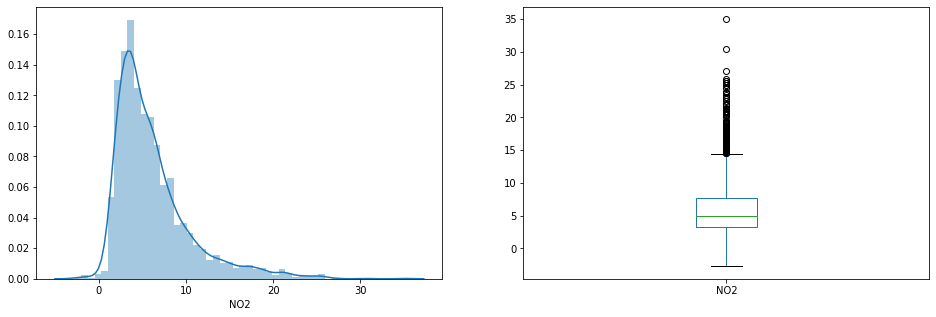

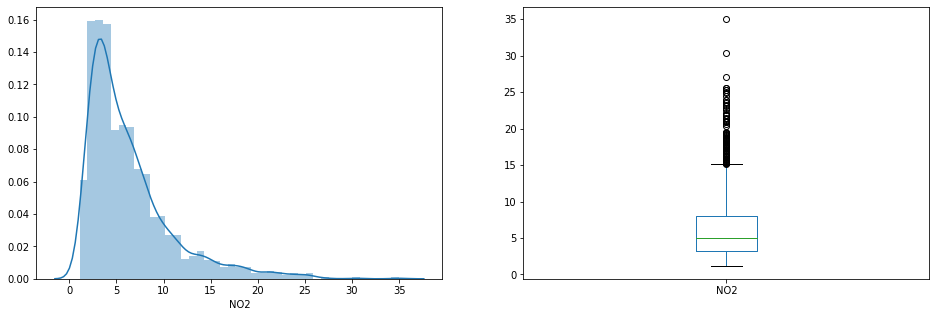

In [521]:
# Visualizing NO2
# plt.figure(1)
plt.subplot(121)
NO2_1 = train_r1_imp['NO2'].dropna()
sns.distplot(NO2_1);

plt.subplot(122)
NO2_1.plot.box(figsize=(16,5))

plt.show()


plt.subplot(121)
NO2_1 = train_r1['NO2'].dropna()
sns.distplot(NO2_1);

plt.subplot(122)
NO2_1.plot.box(figsize=(16,5))

plt.show()

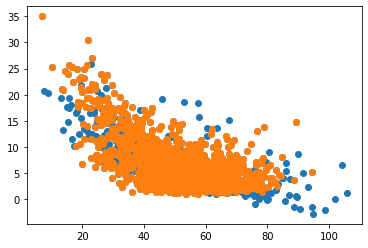

In [522]:
plt.scatter(x=train_r1_imp['O3'], y=train_r1_imp["NO2"])
plt.scatter(x=train_r1['O3'], y=train_r1["NO2"])

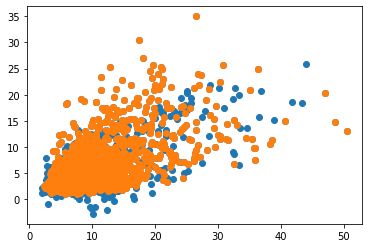

In [523]:
plt.scatter(x=train_r1_imp['PM10'], y=train_r1_imp["NO2"])
plt.scatter(x=train_r1['PM10'], y=train_r1["NO2"])

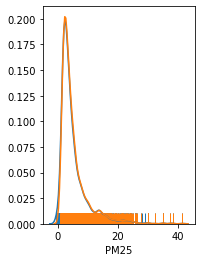

In [524]:
# Visualizing NO2
# plt.figure(1)
plt.subplot(121)
NO2_1_imp = train_r1_imp['PM25'].dropna()
NO2_1 = train_r1['PM25'].dropna()
#sns.distplot(NO2_1_imp)
#sns.distplot(NO2_1)

sns.distplot(NO2_1_imp, hist=False, rug=True)
sns.distplot(NO2_1, hist=False, rug=True)


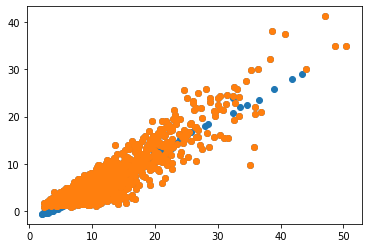

In [525]:
plt.scatter(x=train_r1_imp['PM10'], y=train_r1_imp["PM25"])
plt.scatter(x=train_r1['PM10'], y=train_r1["PM25"])

In [526]:
train_r1_imp['PM25'].describe(), train_r1['PM25'].describe()

(count    2191.000000
 mean        5.203471
 std         4.763241
 min        -0.637464
 25%         2.328000
 50%         3.636000
 75%         6.168382
 max        41.255000
 Name: PM25, dtype: float64, count    1827.000000
 mean        5.368816
 std         4.773007
 min         0.904000
 25%         2.451500
 50%         3.802000
 75%         6.269000
 max        41.255000
 Name: PM25, dtype: float64)

In [0]:
## changing negative values to min value
train_r1_imp['PM25'] = np.where(train_r1_imp['PM25']<=0, 0.904000, train_r1_imp['PM25'] )

In [528]:
train_r1_imp['NO2'].describe(), train_r1['NO2'].describe()

(count    2191.000000
 mean        6.163867
 std         4.376125
 min        -2.754285
 25%         3.228438
 50%         4.988000
 75%         7.737162
 max        34.990000
 Name: NO2, dtype: float64, count    1461.000000
 mean        6.353291
 std         4.572821
 min         1.104000
 25%         3.172000
 50%         4.988000
 75%         7.971000
 max        34.990000
 Name: NO2, dtype: float64)

In [0]:
## changing negative values to min value
train_r1_imp['NO2'] = np.where(train_r1_imp['NO2']<=0, 1.104000, train_r1_imp['NO2'] )

#### Since we are getting good enough results region wise we can impute PM25 and NO2 on the basis of regions

### Region wise imputation

In [531]:
train1.head()

,date,mortality_rate,O3,PM10,PM25,NO2,T2M,Code,Region
0,2007-01-02,2.264,42.358,9.021,NaN,NaN,278.138,E12000001,North East
1,2007-01-03,2.030,49.506,5.256,NaN,NaN,281.745,E12000001,North East
2,2007-01-04,1.874,51.101,4.946,NaN,NaN,280.523,E12000001,North East
3,2007-01-05,2.069,47.478,6.823,NaN,NaN,280.421,E12000001,North East
4,2007-01-06,1.913,45.226,7.532,NaN,NaN,278.961,E12000001,North East


In [535]:
regions = list(region["Region"].values)
train_imp = pd.DataFrame()

for reg in regions:
    
    train_r = train1[train1["Region"] == reg].reset_index(drop=True)
    train_r_imp = mice(train_r.drop(["date", "Code", "Region"], axis = 1).values)
    train_r_imp = pd.DataFrame(train_r_imp, columns = ["mortality_rate", "O3", "PM10", "PM25","NO2","T2M"])
    
    ## changing negative values to min value
    train_r_imp['PM25'] = np.where(train_r_imp['PM25']<=0, min(train_r['PM25']), train_r_imp['PM25'] )
    
    ## changing negative values to min value
    train_r_imp['NO2'] = np.where(train_r_imp['NO2']<=0, min(train_r['NO2']), train_r_imp['NO2'] )
    
    print("\n\n")
    print("train_r = before", train_r.isna().sum())
    
    train_r['PM25'] = train_r_imp['PM25']
    train_r['NO2'] = train_r_imp['NO2']
    train_r['O3'] = train_r_imp['O3']
    train_r['PM10'] = train_r_imp['PM10']
    
    print("train_r_imp = \n", train_r_imp.isna().sum())
    print("train_r = \n", train_r.isna().sum())
    print("----------------------------------------")
    
    train_imp = train_imp.append(train_r)
    
print("train_imp = ", train_imp.isna().sum(), '\n')
    
    




train_r = before date                0
mortality_rate      0
O3                  1
PM10                1
PM25              364
NO2               730
T2M                 0
Code                0
Region              0
dtype: int64
train_r_imp = 
 mortality_rate    0
O3                0
PM10              0
PM25              0
NO2               8
T2M               0
dtype: int64
train_r = 
 date              0
mortality_rate    0
O3                0
PM10              0
PM25              0
NO2               8
T2M               0
Code              0
Region            0
dtype: int64
----------------------------------------



train_r = before date                0
mortality_rate      0
O3                  1
PM10                1
PM25              364
NO2               730
T2M                 0
Code                0
Region              0
dtype: int64
train_r_imp = 
 mortality_rate    0
O3                0
PM10              0
PM25              5
NO2               3
T2M               0
dtype: 

In [0]:
pd.set_option('display.max_rows', None)
#train_imp
                                    

In [537]:
train_imp.head()

,date,mortality_rate,O3,PM10,PM25,NO2,T2M,Code,Region
0,2007-01-02,2.264,42.358,9.021,4.199061,8.413533,278.138,E12000001,North East
1,2007-01-03,2.030,49.506,5.256,1.946919,6.303707,281.745,E12000001,North East
2,2007-01-04,1.874,51.101,4.946,1.870703,6.190103,280.523,E12000001,North East
3,2007-01-05,2.069,47.478,6.823,2.911456,6.977701,280.421,E12000001,North East
4,2007-01-06,1.913,45.226,7.532,3.481354,7.591745,278.961,E12000001,North East


In [538]:
temp_r_imp = mice(train_imp.drop(columns=['date','Code','Region']).values)
temp_r_imp = pd.DataFrame(temp_r_imp, columns = ["mortality_rate", "O3", "PM10", "PM25","NO2","T2M"])

train_r_imp_full = train_imp.copy()
train_r_imp_full["NO2"] = temp_r_imp["NO2"]
train_r_imp_full["PM25"] = temp_r_imp["PM25"]
train_r_imp_full["O3"] = temp_r_imp["O3"]
train_r_imp_full["PM10"] = temp_r_imp["PM10"]

train_r_imp_full.isna().sum()  #### FINAL DATAFRAME WITH IMPUTED VALUES REGION WISE

date              0
mortality_rate    0
O3                0
PM10              0
PM25              0
NO2               0
T2M               0
Code              0
Region            0
dtype: int64

In [539]:
train_r_imp_full.shape, train1.shape

((18403, 9), (18403, 9))

In [540]:
train_r_imp_full.head()

,date,mortality_rate,O3,PM10,PM25,NO2,T2M,Code,Region
0,2007-01-02,2.264,42.358,9.021,4.199061,8.413533,278.138,E12000001,North East
1,2007-01-03,2.030,49.506,5.256,1.946919,6.303707,281.745,E12000001,North East
2,2007-01-04,1.874,51.101,4.946,1.870703,6.190103,280.523,E12000001,North East
3,2007-01-05,2.069,47.478,6.823,2.911456,6.977701,280.421,E12000001,North East
4,2007-01-06,1.913,45.226,7.532,3.481354,7.591745,278.961,E12000001,North East


In [541]:
train_r_imp_full['NO2'].describe()

count    18403.000000
mean         6.220208
std          4.228463
min         -5.469153
25%          3.364170
50%          5.314074
75%          7.764653
max         34.990000
Name: NO2, dtype: float64

In [542]:
train1['NO2'].describe()

count    11833.000000
mean        12.045813
std          8.296675
min          1.104000
25%          6.056000
50%          9.769000
75%         15.858000
max         76.765000
Name: NO2, dtype: float64

In [543]:
train_r_imp_full['PM25'].describe()

count    18403.000000
mean         5.189538
std          4.637969
min          0.274632
25%          2.328000
50%          3.643000
75%          6.114000
max         41.255000
Name: PM25, dtype: float64

In [544]:
train1['PM25'].describe()

count    15127.000000
mean         7.498714
std          5.758357
min          0.904000
25%          3.624000
50%          5.636000
75%          9.326500
max         45.846000
Name: PM25, dtype: float64

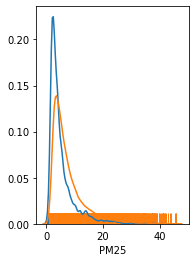

In [545]:
plt.subplot(121)
NO2_1= train1['PM25'].dropna()
NO2_1_imp  = train_r_imp_full['PM25'].dropna()

sns.distplot(NO2_1_imp, hist=False, rug=True)
sns.distplot(NO2_1, hist=False, rug=True)

Region wise imputation is fine but at an overall level it does not suits well..

### Impution on full data - MICE

In [0]:
# start the MICE training
temp_imp = mice(train1.drop(["date", "Code", "Region"], axis = 1).values)
temp_imp = pd.DataFrame(temp_imp, columns = ["mortality_rate", "O3", "PM10", "PM25","NO2","T2M"])

train_full_imp = train1.copy()
train_full_imp["NO2"] = temp_imp["NO2"]
train_full_imp["PM25"] = temp_imp["PM25"]
train_full_imp["O3"] = temp_imp["O3"]
train_full_imp["PM10"] = temp_imp["PM10"]

In [547]:
train_full_imp.isna().sum() ### FINAL DATAFRAME WITH IMPUTATION ON FULL DATA

date              0
mortality_rate    0
O3                0
PM10              0
PM25              0
NO2               0
T2M               0
Code              0
Region            0
dtype: int64

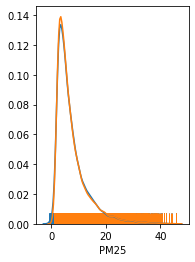

In [548]:
plt.subplot(121)
NO2_1= train1['PM25'].dropna()
NO2_1_imp  = train_full_imp['PM25'].dropna()

sns.distplot(NO2_1_imp, hist=False, rug=True)
sns.distplot(NO2_1, hist=False, rug=True)

#  Feature Engeering

one hot encoding for regions

In [0]:
dummy1= pd.get_dummies(train['region'])
train_f = train.join(dummy1)

dummy2= pd.get_dummies(test['region'])
test_f = test.join(dummy2)

In [550]:
train_f.shape,test_f.shape

((18403, 17), (7886, 16))

doy (day of year) and year

In [0]:
train_f['year'] = train_f['date'].map(lambda x: x.year)
test_f['year'] = test_f['date'].map(lambda x: x.year)

train_f['year^2'] = train_f['year']**2
test_f['year^2'] = test_f['year']**2

train_f['doy'] = train_f['date'].map(lambda x: x.dayofyear)
test_f['doy'] = test_f['date'].map(lambda x: x.dayofyear)

train_f['doy^2'] = train_f['doy']**2
test_f['doy^2'] = test_f['doy']**2

Log Transformation

In [0]:
train_f['NO2_log']=np.log(train_f['NO2'])
train_f['PM10_log']=np.log(train_f['PM10'])
train_f['PM25_log']=np.log(train_f['PM25'])

test_f['NO2_log']=np.log(test_f['NO2'])
test_f['PM10_log']=np.log(test_f['PM10'])
test_f['PM25_log']=np.log(test_f['PM25'])

In [0]:
#train_f.info(),test_f.info()

In [0]:
total_f=total=pd.concat([train_f,test_f],sort=False)

In [0]:
total_f['T2M_rolling'] = total_f.groupby('region')['T2M'].transform(lambda x: x.rolling(30).mean())

In [564]:
total_f.shape

(26289, 25)

In [0]:
train_f=total_f[:18403].dropna()
test_f=total_f[18403:].drop(['mortality_rate'],axis=1)

In [566]:
train_f.shape,test_f.shape

((11833, 25), (7886, 24))

#  Modelling - Regression based models

In [0]:
X_train, X_test, y_train, y_test = train_test_split(train_f.drop(['mortality_rate'],axis=1), train_f['mortality_rate'], test_size=0.2)

In [0]:
#X_train.columns

In [0]:
RMSE= make_scorer(metrics.mean_squared_error)

In [0]:
predictors=['O3','PM10','PM25','NO2','T2M']

In [0]:
X=train_f.drop(['mortality_rate'],axis=1)
y=train_f['mortality_rate']

In [572]:
models = [
    LinearRegression(),
    linear_model.Lasso(alpha=0.1),
    Ridge(alpha=1.0),
    RandomForestRegressor(max_depth=2, random_state=0),
]
CV = 5
for model in models:
    model_name = model.__class__.__name__
    
    accuracies = cross_val_score(model,X[predictors], y,scoring=RMSE, cv=CV)
    
    print(model_name,"RMSE",np.sqrt(accuracies),"\n")
    print("average RMSE :", np.sqrt(accuracies).mean(),"\n","\n")

LinearRegression RMSE [0.25590564 0.2384088  0.23534413 0.24975171 0.21540355] 

average RMSE : 0.23896276599941646 
 

Lasso RMSE [0.26501773 0.24556641 0.2426855  0.25132788 0.21040855] 

average RMSE : 0.243001215350219 
 

Ridge RMSE [0.25590577 0.23840889 0.23534414 0.24975171 0.21540335] 

average RMSE : 0.23896277390564027 
 

RandomForestRegressor RMSE [0.27209648 0.25170445 0.26211702 0.26120663 0.21941687] 

average RMSE : 0.2533082876488943 
 



-LinearRegression      0.2389627659994164  
-Lasso                 0.243001215350219  
-Ridge                 0.2389627739056404  
-RandomForestRegressor 0.2533082876488943   

In [0]:
predictors=['O3','PM10','PM25','NO2_log','T2M']

In [575]:
models = [
    LinearRegression(),
    linear_model.Lasso(alpha=0.1),
    Ridge(alpha=1.0),
    RandomForestRegressor(max_depth=2, random_state=0),
]
CV = 5
for model in models:
    model_name = model.__class__.__name__
    
    accuracies = cross_val_score(model,X[predictors], y,scoring=RMSE, cv=CV)
    
    print(model_name,"RMSE",np.sqrt(accuracies),"\n")
    print("average RMSE :", np.sqrt(accuracies).mean(),"\n","\n")

LinearRegression RMSE [0.26527521 0.24409334 0.24623856 0.25499492 0.21608415] 

average RMSE : 0.24533723378104755 
 

Lasso RMSE [0.27885318 0.25456861 0.25885199 0.26576436 0.21011588] 

average RMSE : 0.25363080541258476 
 

Ridge RMSE [0.26527777 0.24409446 0.24624209 0.25499278 0.21607701] 

average RMSE : 0.245336823902999 
 

RandomForestRegressor RMSE [0.27209715 0.25170576 0.26211702 0.26120663 0.21941673] 

average RMSE : 0.253308657930002 
 



-LinearRegression      0.2453372337810475 
-Lasso                 0.25363080541258476  
-Ridge                 0.24533682390299894 
-RandomForestRegressor 0.253308657930002   

-LB socre
-LinearRegression  0.   
-Lasso             0. 
-Ridge             0. 
-RandomForestRegressor 0. 

In [0]:
predictors=['O3','PM10','PM25_log','NO2_log','T2M']

In [577]:
models = [
    LinearRegression(),
    linear_model.Lasso(alpha=0.1),
    Ridge(alpha=1.0),
    RandomForestRegressor(max_depth=2, random_state=0),
]
CV = 5
for model in models:
    model_name = model.__class__.__name__
    
    accuracies = cross_val_score(model,X[predictors], y,scoring=RMSE, cv=CV)
    
    print(model_name,"RMSE",np.sqrt(accuracies),"\n")
    print("average RMSE :", np.sqrt(accuracies).mean(),"\n","\n")

LinearRegression RMSE [0.26573681 0.24385109 0.24598684 0.25584064 0.21617526] 

average RMSE : 0.24551812699677641 
 

Lasso RMSE [0.27885318 0.25456861 0.25887388 0.26576436 0.21014656] 

average RMSE : 0.25364131894103525 
 

Ridge RMSE [0.26573761 0.24385154 0.24599058 0.25583575 0.21616531] 

average RMSE : 0.24551615920223022 
 

RandomForestRegressor RMSE [0.27209715 0.25170576 0.26211702 0.26120663 0.21941673] 

average RMSE : 0.253308657930002 
 



-LinearRegression      0.24551812699677633 
-Lasso                 0.25364131894103525  
-Ridge                 0.2455161592022304     
-RandomForestRegressor 0.253308657930002   

-LB socre
-LinearRegression  0. 
-Lasso             0.  
-Ridge             0.  
-RandomForestRegressor 0. 

In [0]:
predictors=['O3','PM10_log','PM25_log','NO2_log','T2M']

In [579]:
models = [
    LinearRegression(),
    linear_model.Lasso(alpha=0.1),
    Ridge(alpha=1.0),
    RandomForestRegressor(max_depth=2, random_state=0),
]
CV = 5
for model in models:
    model_name = model.__class__.__name__
    
    accuracies = cross_val_score(model,X[predictors], y,scoring=RMSE, cv=CV)
    
    print(model_name,"RMSE",np.sqrt(accuracies),"\n")
    print("average RMSE :", np.sqrt(accuracies).mean(),"\n","\n")

LinearRegression RMSE [0.26538614 0.24372114 0.24603913 0.25564884 0.21685364] 

average RMSE : 0.24552977824727953 
 

Lasso RMSE [0.27929634 0.25339599 0.25973473 0.266214   0.20971769] 

average RMSE : 0.2536717498662236 
 

Ridge RMSE [0.26538775 0.24372201 0.24604302 0.25564373 0.21683963] 

average RMSE : 0.24552722559739473 
 

RandomForestRegressor RMSE [0.27209715 0.25170576 0.26211702 0.26120663 0.21941673] 

average RMSE : 0.253308657930002 
 



-LinearRegression      0.24552977824727984 
-Lasso                 0.2536717498662236   
-Ridge                 0.2455272255973945      
-RandomForestRegressor 0.253308657930002   

-LB socre
-LinearRegression  0. 
-Lasso             0. 
-Ridge              0.  
-RandomForestRegressor 0. 

In [0]:
predictors=['O3','PM10_log','PM25_log','NO2_log','T2M_rolling']

In [581]:
models = [
    LinearRegression(),
    linear_model.Lasso(alpha=0.1),
    Ridge(alpha=1.0),
    RandomForestRegressor(max_depth=2, random_state=0),
]
CV = 5
for model in models:
    model_name = model.__class__.__name__
    
    accuracies = cross_val_score(model,X[predictors], y,scoring=RMSE, cv=CV)
    
    print(model_name,"RMSE",np.sqrt(accuracies),"\n")
    print("average RMSE :", np.sqrt(accuracies).mean(),"\n","\n")

LinearRegression RMSE [0.25155239 0.22712925 0.23355815 0.23378694 0.19377511] 

average RMSE : 0.22796036576314554 
 

Lasso RMSE [0.27481783 0.24113615 0.2507425  0.25340696 0.19165394] 

average RMSE : 0.24235147415525443 
 

Ridge RMSE [0.25155614 0.22712616 0.23356111 0.23378118 0.19376374] 

average RMSE : 0.22795766522705357 
 

RandomForestRegressor RMSE [0.27247375 0.245499   0.25977973 0.25826535 0.1943188 ] 

average RMSE : 0.2460673252607887 
 



-LinearRegression      0.22796036576314532 
-Lasso                 0.24235147415525443   
-Ridge                 0.2279576652270535  
-RandomForestRegressor 0.2460673252607887 

-LB score
-LinearRegression  0.  
-Lasso             0.
-Ridge              0.  
-RandomForestRegressor 0. 

In [0]:
predictors=['O3','PM10_log','PM25_log','NO2_log','T2M_rolling','year','year^2','doy','doy^2']

In [583]:
models = [
    LinearRegression(),
    linear_model.Lasso(alpha=0.1),
    Ridge(alpha=1.0),
    RandomForestRegressor(max_depth=2, random_state=0),
]
CV = 5
for model in models:
    model_name = model.__class__.__name__
    
    accuracies = cross_val_score(model,X[predictors], y,scoring=RMSE, cv=CV)
    
    print(model_name,"RMSE",np.sqrt(accuracies),"\n")
    print("average RMSE :", np.sqrt(accuracies).mean(),"\n","\n")

LinearRegression RMSE [0.23254874 0.23921699 0.22731851 0.22662792 0.35888154] 

average RMSE : 0.25691874212147575 
 

Lasso RMSE [0.25560805 0.24021627 0.24247718 0.2659596  0.24291558] 

average RMSE : 0.24943533679256355 
 

Ridge RMSE [0.23454083 0.22509922 0.23005836 0.23010584 0.2357758 ] 

average RMSE : 0.23111601199135529 
 

RandomForestRegressor RMSE [0.26795454 0.24061164 0.25503314 0.26202193 0.19208895] 

average RMSE : 0.2435420386323374 
 



-LinearRegression      0.25691874212490495  
-Lasso                 0.24943533679256355  
-Ridge                 0.23111601199135615     
-RandomForestRegressor 0.2435420386323374  

-LB score
-LinearRegression  0.  
-Lasso             0.
-Ridge              0.  
-RandomForestRegressor 0. 

In [0]:
predictors=['T2M_rolling', 'year', 'year^2', 'doy', 'doy^2','E12000001', 'E12000002', 'E12000003', 'E12000004','E12000005', 'E12000006', 'E12000007', 'E12000008']

In [585]:
models = [
    LinearRegression(),
    linear_model.Lasso(alpha=0.1),
    Ridge(alpha=1.0),
    RandomForestRegressor(max_depth=2, random_state=0),
]
CV = 5
for model in models:
    model_name = model.__class__.__name__
    
    accuracies = cross_val_score(model,X[predictors], y,scoring=RMSE, cv=CV)
    
    print(model_name,"RMSE",np.sqrt(accuracies),"\n")
    print("average RMSE :", np.sqrt(accuracies).mean(),"\n","\n")

LinearRegression RMSE [0.20415681 0.18456036 0.17517828 0.16492889 0.24821156] 

average RMSE : 0.19540717885988548 
 

Lasso RMSE [0.25597775 0.24258855 0.24892019 0.2694917  0.23816366] 

average RMSE : 0.2510283706219428 
 

Ridge RMSE [0.2017823  0.18332612 0.17372941 0.16563076 0.19561269] 

average RMSE : 0.18401625729827084 
 

RandomForestRegressor RMSE [0.24741372 0.22554667 0.19961574 0.21522269 0.19597469] 

average RMSE : 0.2167547019932517 
 



In [0]:
predictors1=['NO2_log', 'year', 'year^2', 'doy', 'doy^2','PM10_log']
predictors2=['T2M_rolling', 'year', 'year^2', 'doy', 'doy^2','E12000001', 'E12000002', 'E12000003', 'E12000004','E12000005', 'E12000006', 'E12000007', 'E12000008']
predictors3=['E12000001', 'E12000002', 'E12000003', 'E12000004','E12000005', 'E12000006', 'E12000007', 'E12000008']

In [587]:
pred = [
    predictors1,
    predictors2,
    predictors3,
]
for preds in pred:
    #model_name = model.__class__.__name__
    
    accuracies = cross_val_score(LinearRegression(),X[preds], y,scoring=RMSE, cv=CV)
    
    print(model_name,"RMSE",np.sqrt(accuracies),"\n")
    print("average RMSE :", np.sqrt(accuracies).mean(),"\n","\n")

RandomForestRegressor RMSE [0.23201375 0.26048128 0.22666889 0.25644528 0.42542438] 

average RMSE : 0.28020671587939494 
 

RandomForestRegressor RMSE [0.20415681 0.18456036 0.17517828 0.16492889 0.24821156] 

average RMSE : 0.19540717885988548 
 

RandomForestRegressor RMSE [0.28887085 0.26111306 0.24310381 0.22983521 0.22967401] 

average RMSE : 0.25051938878501434 
 



## Final Algo - mixed LR


Notation:
X0 - training predictors
y0 - training target
X1 - test predictors
y1 - predictions


In [0]:
a = LinearRegression()
b = LinearRegression()
c = LinearRegression()
ab = LinearRegression()

In [0]:

y0 = train_f['mortality_rate']



#modela
a_predictors = ['NO2_log', 'year', 'year^2', 'doy', 'doy^2','PM10_log']
a_X0 = train_f[a_predictors]
a.fit(a_X0, y0)



#modelb
b_predictors = [
        'T2M_rolling', 'year', 'year^2', 'doy', 'doy^2',
        'E12000001', 'E12000002', 'E12000003', 'E12000004',
        'E12000005', 'E12000006', 'E12000007', 'E12000008'
        ]
b_X0 = train_f[b_predictors]
b.fit(b_X0, y0)



#modelc
c_predictors = [
        'E12000001', 'E12000002', 'E12000003', 'E12000004',
        'E12000005', 'E12000006', 'E12000007', 'E12000008'
        ]
c_X0 = train_f[c_predictors]
c.fit(c_X0, y0)


region_effect_reduction = 0.85


# Model AB
# Produces the final solution. Combines A and "reduced B" by using their predictions as features for a linear regression.

ab_X0 = pd.DataFrame({
    'A': a.predict(a_X0),
    'reduced B': b.predict(b_X0) - (c.predict(c_X0) * region_effect_reduction)
    })

ab.fit(ab_X0, y0)

# predict

a_X1 = test_f[a_predictors]
b_X1 = test_f[b_predictors]
c_X1 = test_f[c_predictors]

ab_X1 = pd.DataFrame({'A': a.predict(a_X1),'reduced B': b.predict(b_X1) - (c.predict(c_X1) * region_effect_reduction)})

ab_y1 = ab.predict(ab_X1)



predictions = pd.DataFrame(index=test_f.index)
#predictions['mortality_rate'] =  a.predict(a_X1)
predictions['mortality_rate'] = ab_y1
predictions.to_csv('final_0.0.csv')


# Results
best LB socre for -(region_effect_reduction = 0.85)<br>
private score - 0.28948<br>
public score - 0.28784<br>


benchmark -<br>
private score - 0.29022<br>
public socre - 0.29259<br>